# ML Models Using GPR,TRC, Drainage C139

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import scipy.stats

# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import statsmodels.api as sms

# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# Support Vector Regression
from sklearn.svm import SVR

# KNN
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 

# ANN Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import optimizers

# ANN MLP
from sklearn.neural_network import MLPRegressor

%matplotlib inline

#####ADDED TO SUPPRESS WARNINGS
import warnings
warnings.filterwarnings("ignore")
#####ADDED TO SUPPRESS WARNINGS


Using TensorFlow backend.


In [2]:
# Global variables
FeatureFile = '.\data\SF401OUT_Nov19.xlsx'
random_state = 123 
combined_priority = 4.9 # Combined value above this are priority for attention

In [3]:
# Read feature file
featureDF_all = pd.read_excel(FeatureFile)

# Drop rows with Nan
featureDF = featureDF_all.dropna()

featureDF = featureDF.reset_index()
featureDF.loc[0:2,:]

,index,METRAGE,Start Km,End Km,PVCLeft,PVCCentre,PVCRight,LRILeft,LRICentre,LRIRight,...,SDVersL3,SDVersL4,SDVersR1,SDVersR2,SDVersR3,SDVersR4,Combined1,Combined2,Combined3,Combined4
0,12,0.0625,0.060,0.065,60.8,100.0,28.7,0.0,0.0,0.0,...,4.808974,4.534791,1.082056,0.986533,2.488432,1.363691,4.076771,4.252237,7.860953,5.918670
1,15,0.0775,0.075,0.080,-999.0,-999.0,100.0,0.0,0.0,0.0,...,5.896673,5.555725,1.526795,1.976885,3.224608,1.680394,6.626262,7.315282,6.145940,7.500517
2,18,0.0925,0.090,0.095,-999.0,37.0,98.4,0.0,0.0,0.0,...,2.756668,2.307324,1.922914,2.422018,2.330882,2.053089,5.804191,7.302238,5.223970,5.354201


## Initial Model Params

In [4]:
## The following columns are not included as features
# METRAGE = not a predictor of defect
# Start Km = not a predictor of defect
# End Km = not a predictor of defect
# SDTopLeft4 = the 4th (most recent) TRC data used as a predictor, so assume not available to train
# SDTopRight4 = the 4th (most recent) TRC data used as a predictor, so assume not available to train
# SDTwist104 = the 4th (most recent) TRC data used as a predictor, so assume not available to train
# SDTwist34 = the 4th (most recent) TRC data used as a predictor, so assume not available to train
# SDVersL4 = the 4th (most recent) TRC data used as a predictor, so assume not available to train
# SDVersR4 = the 4th (most recent) TRC data used as a predictor, so assume not available to train
# Combined1 = derived from other predictors (eg SDTwist3)
# Combined2 = derived from other predictors (eg SDTwist3)
# Combined3 = derived from other predictors (eg SDTwist3)
# Combined4 = response

## The following are predictors
# PVCLeft
# PVCCentre
# PVCRight
# LRILeft
# LRICentre
# LRIRight
# BTILeft
# BTICentre
# BTIRight
# MLILeft
# MLICentre
# MLIRight
# FDLLeft
# FDLCentre
# FDLRight
# BVMLeftVolume
# BVMLeftCategory
# BVMCentreVolume
# BVMCentreCategory
# BVMRightVolume
# BVMRightCategory
# BDMLeft
# BDMCentre
# BDMRight
# TDILeft
# TDIRight
# SMI
# Drainage
# SDTopLeft1
# SDTopLeft2
# SDTopLeft3
# SDTopRight1
# SDTopRight2
# SDTopRight3
# SDTwist101
# SDTwist102
# SDTwist103
# SDTwist31
# SDTwist32
# SDTwist33
# SDVersL1
# SDVersL2
# SDVersL3
# SDVersR1
# SDVersR2
# SDVersR3

## Response variable
# Combined4 = response


In [5]:
# Create train and test datsets
test_proportion = 0.25
nSamples = featureDF.shape[0] # number of observations
non_features = ['index', 'METRAGE', 'Start Km', 'End Km', 'SDTopLeft4', 'SDTopRight4', 'Combined1','SDTwist104', 
                'SDTwist34','SDVersL4', 'SDVersR4', 'Combined1', 'Combined2', 'Combined3', 'Combined4']

indices = range(nSamples)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(featureDF, 
        featureDF[['Combined4', 'SDTwist34', 'SDTopLeft4', 'SDTopRight4']],indices, test_size=test_proportion, 
                                                                            random_state = random_state)

# Extract for use in non-combined predictions
y_trainTL = y_train['SDTopLeft4']  
y_trainTR = y_train['SDTopRight4']
y_trainT3 = y_train['SDTwist34']
y_testTL = y_test['SDTopLeft4']  
y_testTR = y_test['SDTopRight4']
y_testT3 = y_test['SDTwist34']

# Primary response
y_test = y_test['Combined4']
y_train = y_train['Combined4']
y_test_array = y_test.reset_index(drop=True)

# Drop non-feature columns
X_train = X_train.drop(non_features, axis=1)
X_test = X_test.drop(non_features, axis=1)
nFeatures = X_train.shape[1] # number of features

# For use in cross validation - do not split training and test
X = featureDF.drop(non_features, axis=1)
y = featureDF['Combined4']

# Get mean of y_test for model assessment
y_test_mean = np.mean(y_test)

# Normalise features
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X_train.columns)

In [6]:
#### Function to plot predicted versus true values
def plot_predicted_actual(model_pred, model_string, model_accuracy): 
    plt.scatter(model_pred, y_test)
    plot_title = model_string + ' test accuracy:' + str(round(model_accuracy, 2)) + '%' 
    plt.title(plot_title, fontsize=12)
    plt.xlabel('Predicted (test)', fontsize=10)
    plt.ylabel('Actual (test)', fontsize=10)

    # Plot line of best fit
    plt.plot(np.unique(model_pred), np.poly1d(np.polyfit(model_pred, y_test, 1))(np.unique(model_pred)), 
             color='red')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(model_pred, y_test)
    M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
    plt.text(4,6,M_string, color='red')               
    plt.show()

In [7]:
#### Function to plot high priority predicted versus true values
def assessPriorityPredictions(model_pred, model_string, response_priority):
    # Consider high priority predictions where y_test > response_priority
    y_test_priority_index = np.where(y_test_array >= response_priority)[0] 
    # Add high priority predictions where prediction > response priority
    model_priority_pred_index = np.where(model_pred >= response_priority)[0]
    model_priority_index = np.unique( np.concatenate((y_test_priority_index, model_priority_pred_index), 
                                                         axis=None) )
    y_test_priority = y_test_array[model_priority_index]
    model_priority_pred = model_pred[model_priority_index]

    model_priority_errors = abs(model_priority_pred - y_test_priority)

    # Calculate mean absolute percentage error (MAPE)
    model_prioritymape = 100 * (model_priority_errors / y_test_priority)
    model_priorityaccuracy = 100 - np.mean(model_prioritymape)
    print(model_string, 'accuracy:', round(model_priorityaccuracy, 2), '%.')

    plt.scatter(model_priority_pred, y_test_priority)
    plot_title = model_string + ' test accuracy:' + str(round(model_priorityaccuracy, 2)) + '%' 
    plt.title(plot_title, fontsize=12)
    plt.xlabel('Predicted (test)', fontsize=10)
    plt.ylabel('Actual (test)', fontsize=10)

    # Plot line of best fit
    plt.plot(np.unique(model_priority_pred), np.poly1d(np.polyfit(model_priority_pred, y_test_priority, 1))(np.unique(model_priority_pred)), color='red')
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(model_priority_pred, y_test_priority)
    M_string = 'M = ' + str(round(slope,2)) + ', R = ' + str(round(r_value,2))# Extract gradient ~1.0
    plt.text(4,3.5,M_string, color='red')               
    plt.show()

## Investigate response data 

Summary of Combined response: count    1650.000000
mean        2.874873
std         1.206252
min         0.961385
25%         2.013109
50%         2.618403
75%         3.472104
max        10.094321
Name: Combined4, dtype: float64


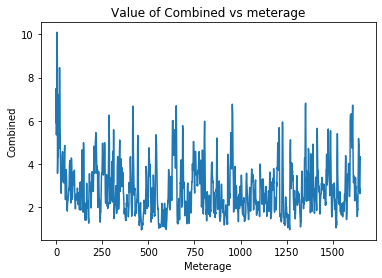

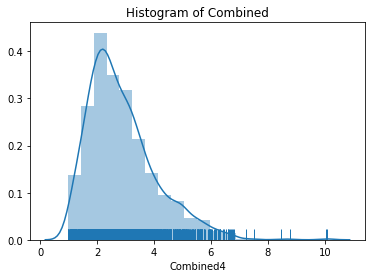

In [8]:
print('Summary of Combined response:', y.describe())

# Plot instances of Combined4
plot_title = 'Value of Combined vs meterage' 
plt.title(plot_title, fontsize=12)
plt.xlabel('Meterage', fontsize=10)
plt.ylabel('Combined', fontsize=10)
plt.plot(featureDF['Combined4'])
plt.show()

# Investigate distribution of the response
ax = sns.distplot(y, bins=20, kde=True, rug=True)
ax.set_title('Histogram of Combined', fontsize=12)
plt.show()

Exponentiated Weibull params:
alpha (shape): 2.0989 k (shape): 1.2076
loc: 0.8678 lambda (scale): 1.4486


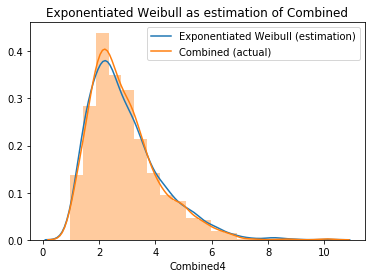

array([0.5488135 , 0.71518937, 0.60276338, ..., 0.07799282, 0.80493557,
       0.06659633])

In [11]:
# Estimate the response using Exponentiated Weibull distribution
weib_params = scipy.stats.exponweib.fit(y)
print('Exponentiated Weibull params:')
print('alpha (shape):', round(weib_params[0],4), 'k (shape):', round(weib_params[1],4))
print('loc:', round(weib_params[2],4), 'lambda (scale):', round(weib_params[3],4))

# Generate sample random variables to compare with actual distribution
weib_rv = scipy.stats.exponweib.rvs(*weib_params, len(y), random_state = 0)

# Plot estimated distribution versus actual
sns.distplot(weib_rv, hist=False, rug=False, label='Exponentiated Weibull (estimation)')
sns.distplot(y, bins=20, kde=True, rug=False, kde_kws={"label": 'Combined (actual)'})
plt.title('Exponentiated Weibull as estimation of Combined')
ax.set_xlabel('Combined')
ax.set_ylabel('Frequency')
plt.show()

# Calculate CDF of estimated distribution
scipy.stats.exponweib.cdf(weib_rv, *weib_params)


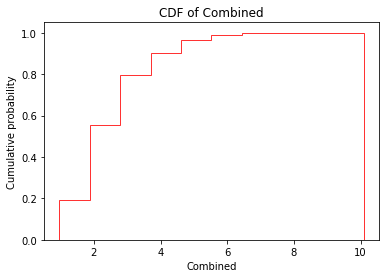

Probability sample exceeds threshold: 7.64 %


In [12]:
# Investigate CDF
plt.hist(y, normed=True, cumulative=True, histtype='step', alpha=0.8, color='r')
plt.title('CDF of Combined')
plt.xlabel('Combined')
plt.ylabel('Cumulative probability')
plt.show()

prob_gt_combined_priority = np.sum(y>combined_priority)/len(y)*100
print('Probability sample exceeds threshold:', round(prob_gt_combined_priority,2),'%')

In [13]:
###### REF: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

# Estimate the distribution of 
# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    import scipy.stats as st
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get same start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

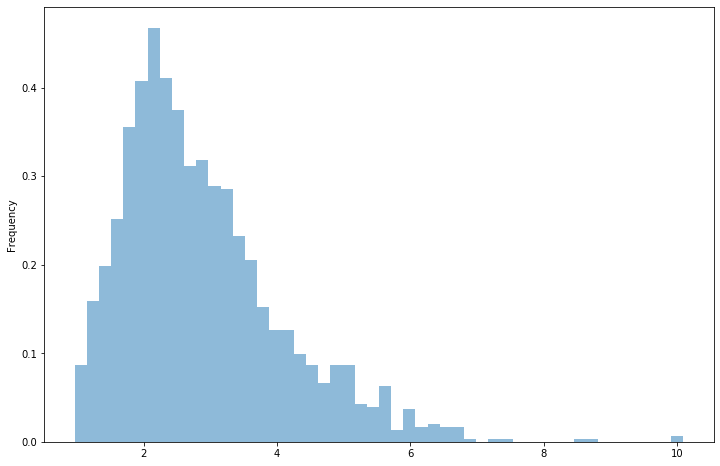

In [100]:
##################################################
########## CAUTION EXCEPTIONALLY SLOW ############
##################################################

# Plot for comparison
plt.figure(figsize=(12,8))
ax_dist = featureDF['Combined4'].plot(kind='hist', bins=50, normed=True, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data=featureDF['Combined4'], bins=200)#, ax=ax_dist)
best_dist = getattr(st, best_fit_name)

Text(0, 0.5, 'Frequency')

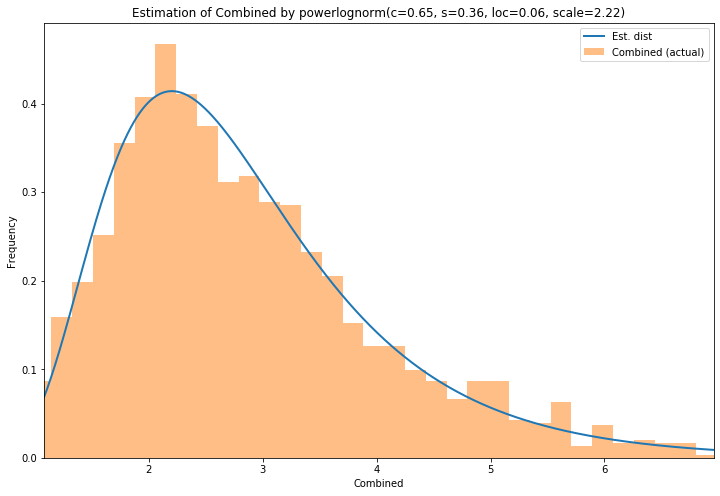

In [107]:
# Update plots
ax.set_ylim(dataYLim)
ax.set_title('Estimation of Combined Distribution')
ax.set_xlabel('Combined')
ax.set_ylabel('Frequency')

# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='Est. dist', legend=True)
y.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Combined (actual)', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)
ax.set_title('Estimation of Combined by ' + dist_str)
ax.set_xlabel('Combined')
ax.set_ylabel('Frequency')

### Baseline Accuracy

#### Use mean of training response variable

Baseline accuracy (using mean only): 63.86 %.


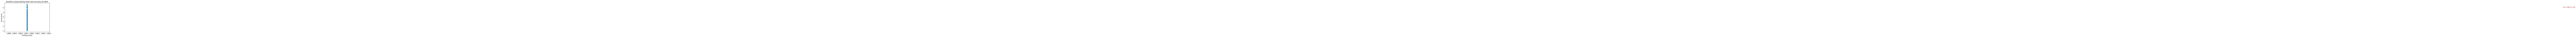

In [14]:
baseline1_pred = [np.mean(y_train)]*len(y_test)
baseline1_errors = abs(baseline1_pred - y_test)

# Calculate mean absolute percentage error (MAPE)
baseline1mape = 100 * (baseline1_errors / y_test)
baseline1accuracy = 100 - np.mean(baseline1mape)
print('Baseline accuracy (using mean only):', round(baseline1accuracy, 2), '%.')

plot_predicted_actual(baseline1_pred, 'Baseline using training mean', baseline1accuracy)

Baseline (training mean) accuracy: 52.97 %.


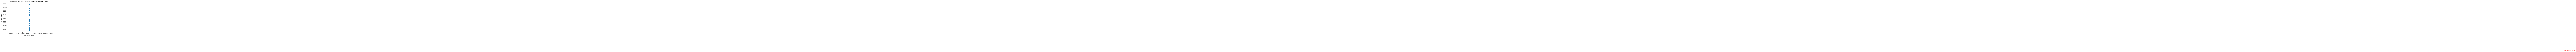

In [15]:
assessPriorityPredictions(np.asarray(baseline1_pred), "Baseline (training mean)", combined_priority)

#### Use most recent TRC response as prediction

Baseline accuracy (using most recent TRC only): 80.92 %.


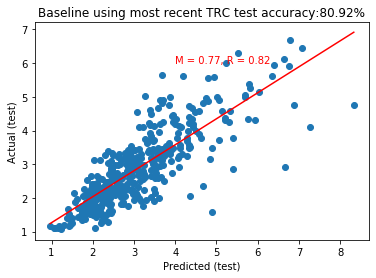

In [16]:
baseline2_pred = featureDF.loc[indices_test,'Combined3'] # Use most recent TRC 'Combined' value
baseline2_errors = abs(baseline2_pred - y_test)

# Calculate mean absolute percentage error (MAPE)
baseline2mape = 100 * (baseline2_errors / y_test)
baseline2accuracy = 100 - np.mean(baseline2mape)
print('Baseline accuracy (using most recent TRC only):', round(baseline2accuracy, 2), '%.')

plot_predicted_actual(baseline2_pred, 'Baseline using most recent TRC', baseline2accuracy)

Baseline (most recent TRC value) accuracy: 73.69 %.


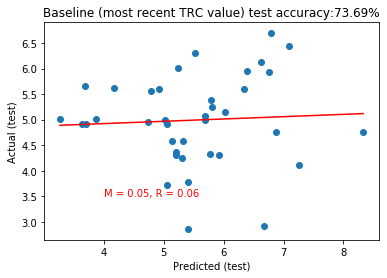

In [17]:
assessPriorityPredictions(baseline2_pred.values, "Baseline (most recent TRC value)", combined_priority)

Baseline accuracy TC (using most recent TRC only): 79.52 %.


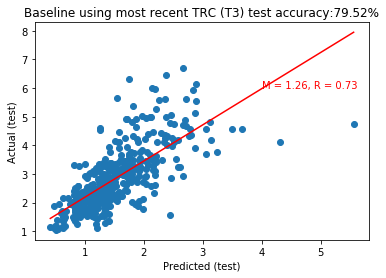

Baseline T3 (most recent TRC value) accuracy: 52.0 %.


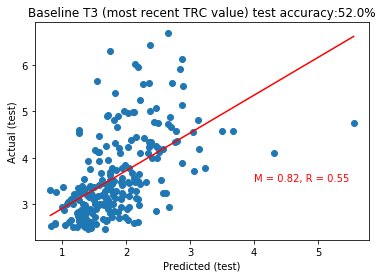

In [18]:
# Baseline for Twist3
baseline2_predT3 = featureDF.loc[indices_test,'SDTwist33'] # Use most recent TRC value
baseline2_errorsT3 = abs(baseline2_predT3 - y_testT3)

# Calculate mean absolute percentage error (MAPE)
baseline2mapeT3 = 100 * (baseline2_errorsT3 / y_testT3)
baseline2accuracyT3 = 100 - np.mean(baseline2mapeT3)
print('Baseline accuracy TC (using most recent TRC only):', round(baseline2accuracyT3, 2), '%.')

plot_predicted_actual(baseline2_predT3, 'Baseline using most recent TRC (T3)', baseline2accuracyT3)
assessPriorityPredictions(baseline2_predT3.values, "Baseline T3 (most recent TRC value)", combined_priority/2)

Baseline accuracy TL (using most recent TRC only): 65.06 %.


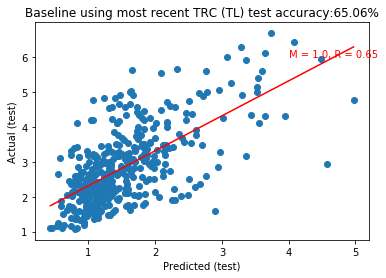

Baseline TL (most recent TRC value) accuracy: 50.34 %.


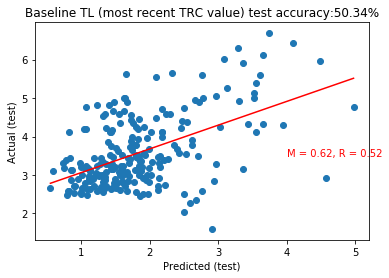

In [19]:
# Baseline for TopLeft
baseline2_predTL = featureDF.loc[indices_test,'SDTopLeft3'] # Use most recent TRC value
baseline2_errorsTL = abs(baseline2_predTL - y_testTL)

# Calculate mean absolute percentage error (MAPE)
baseline2mapeTL = 100 * (baseline2_errorsTL / y_testTL)
baseline2accuracyTL = 100 - np.mean(baseline2mapeTL)
print('Baseline accuracy TL (using most recent TRC only):', round(baseline2accuracyTL, 2), '%.')

plot_predicted_actual(baseline2_predTL, 'Baseline using most recent TRC (TL)', baseline2accuracyTL)
assessPriorityPredictions(baseline2_predTL.values, "Baseline TL (most recent TRC value)", combined_priority/2)

Baseline accuracy TR (using most recent TRC only): 60.97 %.


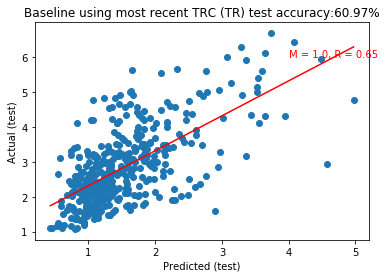

Baseline TR (most recent TRC value) accuracy: 50.34 %.


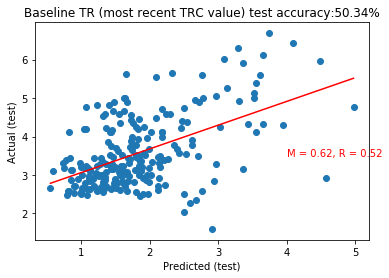

In [20]:
# Baseline for TopRight
baseline2_predTR = featureDF.loc[indices_test,'SDTopLeft3'] # Use most recent TRC value
baseline2_errorsTR = abs(baseline2_predTR - y_testTR)

# Calculate mean absolute percentage error (MAPE)
baseline2mapeTR = 100 * (baseline2_errorsTR / y_testTR)
baseline2accuracyTR = 100 - np.mean(baseline2mapeTR)
print('Baseline accuracy TR (using most recent TRC only):', round(baseline2accuracyTR, 2), '%.')

plot_predicted_actual(baseline2_predTR, 'Baseline using most recent TRC (TR)', baseline2accuracyTR)
assessPriorityPredictions(baseline2_predTR.values, "Baseline TR (most recent TRC value)", combined_priority/2)

### Linear Regression 


#### Not Normalised

In [21]:
# Create linear regression model
LRmodel = LinearRegression(fit_intercept = True, normalize = False)
LRmodel.fit(X_train, y_train)

r2 = LRmodel.score(X_train, y_train)
print('Coefficient of determination:', round(r2,4))

# Generate predictions and assess accuracy
LR_pred = LRmodel.predict(X_test)
LRerrors = abs(LR_pred - y_test)

# Calculate mean absolute percentage error (MAPE)
LRmape = 100 * (LRerrors / y_test)
LRaccuracy = 100 - np.mean(LRmape)
print('LR accuracy:', round(LRaccuracy, 2), '%.')

# Obtain coefficients
coeff_df = pd.DataFrame(LRmodel.coef_, X_train.columns, columns=['Coefficient'])  
coeff_df

Coefficient of determination: 0.766
LR accuracy: 83.11 %.


,Coefficient
PVCLeft,-2.385158e-05
PVCCentre,1.227528e-04
PVCRight,7.225473e-05
LRILeft,-4.374742e-02
LRICentre,-4.726476e-02
LRIRight,-1.905463e-03
BTILeft,-4.364432e-02
BTICentre,1.234582e-02
BTIRight,-1.561216e-02
MLILeft,-2.591780e-02


#### Normalised

In [22]:
# Create linear regression model
LRmodel_scaled = LinearRegression(fit_intercept = True, normalize = False)
LRmodel_scaled.fit(X_train_scaled, y_train)

r2 = LRmodel_scaled.score(X_train_scaled, y_train)
print('LR coefficient of determination:', round(r2,4))

# Generate predictions and assess accuracy
LR_pred_scaled = LRmodel_scaled.predict(X_test_scaled)
LRerrors = abs(LR_pred_scaled - y_test)

# Calculate mean absolute percentage error (MAPE)
LRmape = 100 * (LRerrors / y_test)
LRaccuracy = 100 - np.mean(LRmape)
print('LR accuracy:', round(LRaccuracy, 2), '%.')

LR coefficient of determination: 0.766
LR accuracy: 82.84 %.


#### Plot predicted vs. actual

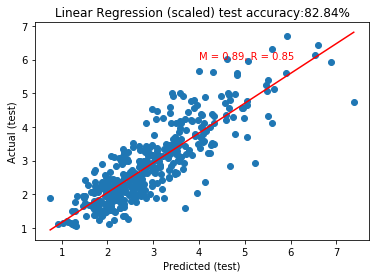

In [23]:
plot_predicted_actual(LR_pred_scaled, 'Linear Regression (scaled)', LRaccuracy)

Linear Regression (scaled vars) accuracy: 81.81 %.


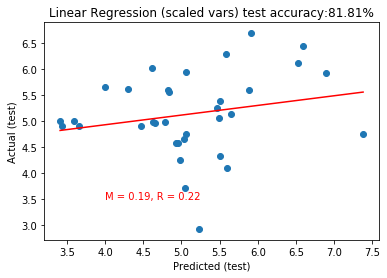

In [24]:
assessPriorityPredictions(LR_pred_scaled, "Linear Regression (scaled vars)", combined_priority)

#### Reduce params based on P-value

In [25]:
# Rerun using OLS to obtain P-values
X_train_features = sms.add_constant(X_train) # Ensure an intercept is provided
OLSmodel = sms.OLS(y_train, X_train)
OLSresults = OLSmodel.fit()
print(OLSresults.summary())

                            OLS Regression Results                            
Dep. Variable:              Combined4   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     86.62
Date:                Thu, 21 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:07:10   Log-Likelihood:                -1122.7
No. Observations:                1237   AIC:                             2337.
Df Residuals:                    1191   BIC:                             2573.
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
PVCLeft           -2.385e-05      0.00

Coefficient of determination: 0.7612
LR accuracy: 83.05 %.


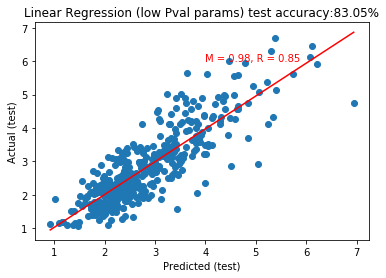

In [26]:
# Extract variables with Pval below threshold
pVal_threshold = 0.2
OLSdrop_features = OLSresults.pvalues[OLSresults.pvalues > pVal_threshold].index

# Drop non-feature columns
X_train_OLS = X_train.drop(OLSdrop_features, axis=1)
X_train_scaled_OLS = X_train_scaled.drop(OLSdrop_features, axis=1)
X_test_OLS = X_test.drop(OLSdrop_features, axis=1)
X_test_scaled_OLS = X_test_scaled.drop(OLSdrop_features, axis=1)
X_OLS = X.drop(OLSdrop_features, axis=1)
X_scaled_OLS = X_scaled.drop(OLSdrop_features, axis=1)

# Create linear regression model
LRmodel_OLS = LinearRegression(fit_intercept = True, normalize = False)
LRmodel_OLS.fit(X_train_OLS, y_train)

r2_OLS = LRmodel_OLS.score(X_train_OLS, y_train)
print('Coefficient of determination:', round(r2_OLS,4))

# Generate predictions and assess accuracy
LR_pred_OLS = LRmodel_OLS.predict(X_test_OLS)
LRerrors_OLS = abs(LR_pred_OLS - y_test)

# Calculate mean absolute percentage error (MAPE)
LRmape_OLS = 100 * (LRerrors_OLS / y_test)
LRaccuracy_OLS = 100 - np.mean(LRmape_OLS)
print('LR accuracy:', round(LRaccuracy_OLS, 2), '%.')

plot_predicted_actual(LR_pred_OLS, 'Linear Regression (low Pval params)', LRaccuracy_OLS)

LR with low P-vals accuracy: 80.52 %.


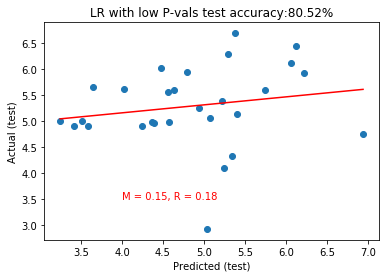

In [27]:
assessPriorityPredictions(LR_pred_OLS, "LR with low P-vals", combined_priority)

#### Cross validation score

In [28]:
# Cross Validation all features
k_folds = 10
LRmodel_CV = LinearRegression(fit_intercept = True, normalize = False)
LRmodel_CV.fit(X, y)

LRscores = cross_val_score(LRmodel_CV, X=X, y=y, cv=k_folds, scoring='r2')
print('LR',k_folds,'fold CV average score:', round(np.mean(LRscores)*100,2),'%')

LR 10 fold CV average score: 33.33 %


In [29]:
# Cross Validation reduced features
k_folds = 10
LRmodel_OLS_CV = LinearRegression(fit_intercept = True, normalize = False)
LRmodel_OLS_CV.fit(X_OLS, y)

LRscores_OLS = cross_val_score(LRmodel_OLS_CV, X=X_OLS, y=y, cv=k_folds, scoring='r2')
print('LR',k_folds,'fold CV average score (reduced features):', round(np.mean(LRscores_OLS)*100,2),'%')

LR 10 fold CV average score (reduced features): 40.81 %


#### LASSO

In [30]:
# Vary alpha to optimise LASSO NB alpha=0 = OLS
alpha_array = [1e-6, 1e-5, 0.0001, 0.01, 0.1, 0.5, 1.0, 5.0, 10, 50, 100]
LASSO_array = [] # array will store alpha, test accuracy, test score and # params

for alpha_iter in alpha_array:
    print('\nalpha:', alpha_iter)
    
    # Create LASSO model
    LASSOmodel = linear_model.Lasso(alpha=alpha_iter, max_iter=1e8)
    LASSOmodel.fit(X_train, y_train)
    LASSOtrain_score = LASSOmodel.score(X_train, y_train)

    # Generate predictions and assess accuracy
    LASSO_pred = LASSOmodel.predict(X_test)
    LASSOerrors = abs(LASSO_pred - y_test)

    # Calculate mean absolute percentage error (MAPE)
    LASSOmape = 100 * (LASSOerrors / y_test)
    LASSOaccuracy = 100 - np.mean(LASSOmape)
    print('LASSO accuracy:', round(LASSOaccuracy, 2), '%.')

    # Obtain test score
    LASSOtest_score = LASSOmodel.score(X_test, y_test)
    LASSOcoeff_used = np.sum(LASSOmodel.coef_!=0)
    print('LASSO test score:', round(LASSOtest_score, 3))
    print('LASSO coefficients used:', LASSOcoeff_used)
    LASSO_array.append([alpha_iter, LASSOaccuracy, LASSOtest_score, LASSOcoeff_used])

LASSO_array = np.asarray(LASSO_array)    


alpha: 1e-06
LASSO accuracy: 83.11 %.
LASSO test score: 0.719
LASSO coefficients used: 45

alpha: 1e-05
LASSO accuracy: 83.11 %.
LASSO test score: 0.719
LASSO coefficients used: 45

alpha: 0.0001
LASSO accuracy: 83.12 %.
LASSO test score: 0.719
LASSO coefficients used: 44

alpha: 0.01
LASSO accuracy: 83.26 %.
LASSO test score: 0.718
LASSO coefficients used: 20

alpha: 0.1
LASSO accuracy: 81.78 %.
LASSO test score: 0.683
LASSO coefficients used: 9

alpha: 0.5
LASSO accuracy: 71.3 %.
LASSO test score: 0.329
LASSO coefficients used: 5

alpha: 1.0
LASSO accuracy: 65.61 %.
LASSO test score: 0.093
LASSO coefficients used: 4

alpha: 5.0
LASSO accuracy: 63.88 %.
LASSO test score: 0.008
LASSO coefficients used: 3

alpha: 10
LASSO accuracy: 63.94 %.
LASSO test score: 0.009
LASSO coefficients used: 3

alpha: 50
LASSO accuracy: 63.86 %.
LASSO test score: -0.002
LASSO coefficients used: 0

alpha: 100
LASSO accuracy: 63.86 %.
LASSO test score: -0.002
LASSO coefficients used: 0


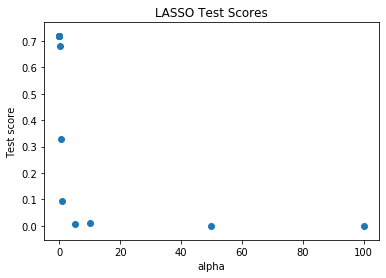

In [31]:
# Plot alpha vs test scores
plt.scatter(LASSO_array[:,0], LASSO_array[:,2])
plt.title('LASSO Test Scores', fontsize=12)
plt.xlabel('alpha', fontsize=10)
plt.ylabel('Test score', fontsize=10)
plt.show()

In [32]:
# Consider optimal alpha as test accuracy x test score
LASSO_optimal_index = np.where(LASSO_array[:,1]*LASSO_array[:,2] ==np.max(LASSO_array[:,1]*LASSO_array[:,2]))[0][0]
LASSO_optimal_alpha = LASSO_array[LASSO_optimal_index, 0]
print('Optimal alpha based on test accuracy and score:',LASSO_optimal_alpha)

# Consider optimal alpha as test accuracy x test score / # coefficients
LASSO_min_score = 0.6 # minimum test score to qualify
LASSO_min_coef = 6 # minimum number of coefficients
LASSO_best_score = 0 # Initialise score
for LASSO_iter in range(LASSO_array.shape[0]):
        if ((LASSO_array[LASSO_iter, 2] >= LASSO_min_score) & (LASSO_array[LASSO_iter, 3] >= LASSO_min_coef)):
            LASSO_working = LASSO_array[LASSO_iter,1]*LASSO_array[LASSO_iter,2]/LASSO_array[LASSO_iter,3] 
            if (LASSO_working > LASSO_best_score):
                LASSO_best_score = LASSO_working
                LASSO_best_alpha = LASSO_array[LASSO_iter,0]
print('Optimal alpha based on test accuracy and #coefficents:',LASSO_best_alpha)

Optimal alpha based on test accuracy and score: 0.01
Optimal alpha based on test accuracy and #coefficents: 0.1


In [33]:
#### Function to perform LASSO for given alpha_var
def LASSO_analysis(alpha_var):
    LASSOmodel = linear_model.Lasso(alpha=alpha_var, max_iter=1e8)
    LASSOmodel.fit(X_train, y_train)
    full_coeff = pd.DataFrame(LASSOmodel.coef_, X_train.columns, columns=['Coefficient'])
    LASSOcoeff_used = full_coeff[full_coeff != 0].dropna()

    print('LASSO alpha:', alpha_var, 'number coefficients used:', LASSOcoeff_used.shape[0])
    print('Coefficients used:', LASSOcoeff_used)

    # Generate predictions and assess accuracy
    LASSO_pred = LASSOmodel.predict(X_test)
    LASSOerrors = abs(LASSO_pred - y_test)

    # Calculate mean absolute percentage error (MAPE)
    LASSOmape = 100 * (LASSOerrors / y_test)
    LASSOaccuracy = 100 - np.mean(LASSOmape)

    # Plot predicted versus actual
    LASSO_string = 'LASSO with alpha: ' + str(alpha_var) 
    plot_predicted_actual(LASSO_pred, LASSO_string, LASSOaccuracy)
    
    # Assess performance against high priority predictions
    assessPriorityPredictions(LASSO_pred, "LASSO_string", combined_priority)
    
    # Return coefficients used in the model
    return LASSOcoeff_used

LASSO alpha: 0.01 number coefficients used: 20
Coefficients used:                   Coefficient
PVCLeft              0.000086
PVCCentre            0.000052
PVCRight            -0.000007
LRILeft             -0.034243
LRICentre           -0.015724
BTILeft             -0.016829
BVMLeftVolume        0.002017
BVMLeftCategory     -0.084558
BVMRightCategory    -0.178190
TDILeft             -0.015378
SDTopLeft1           0.085709
SDTopLeft2           0.027357
SDTopLeft3           0.149756
SDTopRight1          0.002339
SDTopRight3          0.467244
SDTwist101           0.003335
SDTwist103           0.156955
SDTwist33            0.704040
SDVersL1             0.032223
SDVersL3            -0.029777


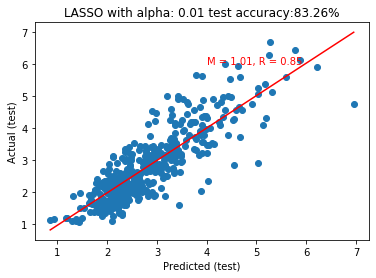

LASSO_string accuracy: 80.64 %.


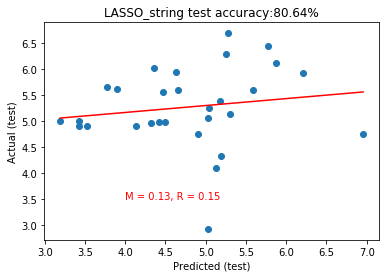

In [34]:
# Investigate optimal alpha
LASSO_opt_coeff = LASSO_analysis(LASSO_optimal_alpha)
LASSO_opt_coeff_array = np.array(LASSO_opt_coeff.index)

# Create subset of features using LASSO
X_train_20 = X_train[LASSO_opt_coeff_array]
X_train_scaled_20 = X_train_scaled[LASSO_opt_coeff_array]
X_test_20 = X_test[LASSO_opt_coeff_array]
X_test_scaled_20 = X_test_scaled[LASSO_opt_coeff_array]
X_20 = X[LASSO_opt_coeff_array]
X_scaled_20 = X_scaled[LASSO_opt_coeff_array]

LASSO alpha: 0.1 number coefficients used: 9
Coefficients used:              Coefficient
PVCLeft         0.000195
PVCCentre      -0.000034
PVCRight       -0.000156
SDTopLeft3      0.139517
SDTopRight3     0.445248
SDTwist101      0.005967
SDTwist103      0.226816
SDTwist33       0.440120
SDVersL1        0.000970


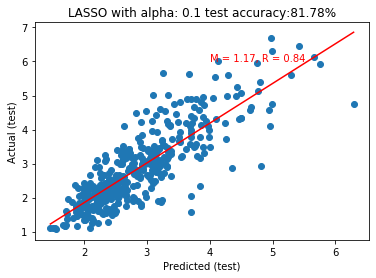

LASSO_string accuracy: 80.27 %.


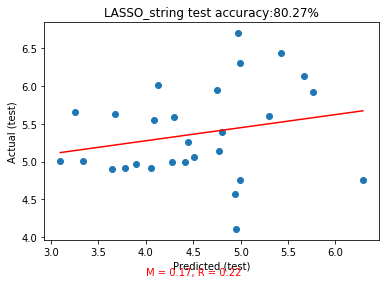

In [35]:
# Investigate 'best' alpha
LASSO_best_coeff = LASSO_analysis(LASSO_best_alpha)
LASSO_best_coeff_array = np.array(LASSO_best_coeff.index)

# Create subset of features using LASSO
X_train_9 = X_train[LASSO_best_coeff_array]
X_train_scaled_9 = X_train_scaled[LASSO_best_coeff_array]
X_test_9 = X_test[LASSO_best_coeff_array]
X_test_scaled_9 = X_test_scaled[LASSO_best_coeff_array]
X_9 = X[LASSO_best_coeff_array]
X_scaled_9 = X_scaled[LASSO_best_coeff_array]

#### Linear Regression Cross validation score reduced features

In [36]:
# Cross Validation
k_folds = 10
LRmodel_scaled_CV_20 = LinearRegression(fit_intercept = True, normalize = True)
LRmodel_scaled_CV_20.fit(X_scaled_20, y)

LRscores = cross_val_score(LRmodel_scaled_CV_20, X=X_scaled_20, y=y, cv=k_folds)
print('LR',k_folds,'fold CV average score:', round(np.mean(LRscores)*100,2),'%')

LR 10 fold CV average score: 42.51 %


#### Elastic Net

In [37]:
ENmodel = linear_model.ElasticNet(random_state = random_state)
ENmodel.fit(X_train, y_train) 
ENsearch = GridSearchCV(estimator=ENmodel, 
                        param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},
                        scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)
ENsearch.fit(X_train, y_train)
print('Optimal Elastic Net paramaters:', ENsearch.best_params_)

Optimal Elastic Net paramaters: {'alpha': 0.01, 'l1_ratio': 0.8}


In [38]:
# Refit using optimal paramaters
EN_optimal_alpha = ENsearch.best_params_['alpha']
EN_optimal_l1_ratio = ENsearch.best_params_['l1_ratio']
ENmodel = linear_model.ElasticNet(alpha=EN_optimal_alpha, l1_ratio=EN_optimal_l1_ratio, random_state = random_state)
ENmodel.fit(X_train, y_train) 

# Generate predictions and assess accuracy
EN_pred =ENmodel.predict(X_test)
ENerrors = abs(EN_pred - y_test)

# Calculate mean absolute percentage error (MAPE)
ENmape = 100 * (ENerrors / y_test)
ENaccuracy = 100 - np.mean(ENmape)
print('Elastic Net accuracy:', round(ENaccuracy, 2), '%.')

# Obtain test score
ENtest_score = ENmodel.score(X_test, y_test)
ENcoeff_used = np.sum(ENmodel.coef_!=0)
print('Elastic Net test score:', round(ENtest_score, 3))
print('Elastic Net coefficients used:', ENcoeff_used)

# Investigate coefficients used
print('\nElastic Net coefficients with alpha:', EN_optimal_alpha, 'and L1 ratio:', EN_optimal_l1_ratio)
print(pd.DataFrame(ENmodel.coef_, X_train.columns, columns=['Coefficient']))


Elastic Net accuracy: 83.21 %.
Elastic Net test score: 0.719
Elastic Net coefficients used: 21

Elastic Net coefficients with alpha: 0.01 and L1 ratio: 0.8
                   Coefficient
PVCLeft               0.000084
PVCCentre             0.000057
PVCRight             -0.000003
LRILeft              -0.035874
LRICentre            -0.016722
LRIRight              0.000000
BTILeft              -0.021647
BTICentre             0.000000
BTIRight             -0.000000
MLILeft              -0.000000
MLICentre             0.000000
MLIRight              0.000000
FDLLeft               0.000000
FDLCentre            -0.000000
FDLRight              0.000000
BVMLeftVolume         0.000462
BVMLeftCategory      -0.086936
BVMCentreVolume      -0.000000
BVMCentreCategory    -0.000000
BVMRightVolume       -0.000000
BVMRightCategory     -0.184974
BDMLeft              -0.000000
BDMCentre             0.000000
BDMRight              0.000000
TDILeft              -0.020529
TDIRight              0.000000
SMI    

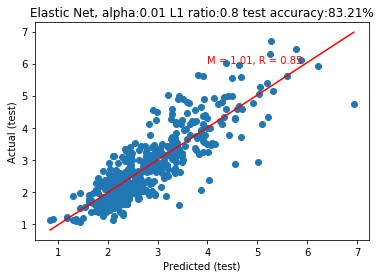

Elastic Net, alpha:0.01 L1 ratio:0.8 accuracy: 80.74 %.


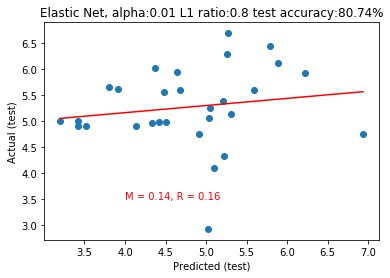

In [39]:
# Assess Elastic Net predicted and actual
EN_string = 'Elastic Net, alpha:' + str(EN_optimal_alpha) +' L1 ratio:' + str(EN_optimal_l1_ratio)
plot_predicted_actual(EN_pred, EN_string, ENaccuracy)
    
# Assess performance against high priority predictions
assessPriorityPredictions(EN_pred, EN_string, combined_priority)    

## Linear Regression with reduced features

#### Reduced features: 9

LR coefficient of determination (features= 9 ) 0.7361


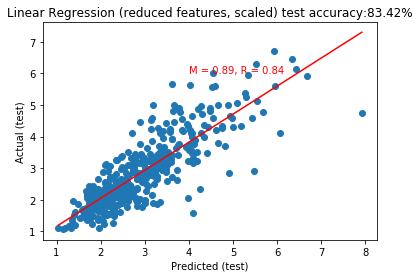

Linear Regression (reduced features, scaled) accuracy: 79.43 %.


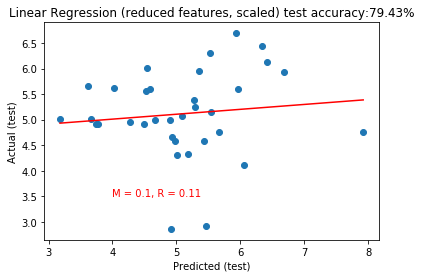

In [40]:
# Create linear regression model
LRmodel_scaled_9 = LinearRegression(fit_intercept = True, normalize = True)
LRmodel_scaled_9.fit(X_train_scaled_9, y_train)

r2 = LRmodel_scaled_9.score(X_train_scaled_9, y_train)
print('LR coefficient of determination (features=', X_9.shape[1],')',round(r2,4))

# Generate predictions and assess accuracy
LR_pred_scaled_9 = LRmodel_scaled_9.predict(X_test_scaled_9)
LRerrors = abs(LR_pred_scaled_9 - y_test)

# Calculate mean absolute percentage error (MAPE)
LRmape = 100 * (LRerrors / y_test)
LRaccuracy = 100 - np.mean(LRmape)

# Assess predicted and actal
LR_string = 'Linear Regression (reduced features, scaled)'
plot_predicted_actual(LR_pred_scaled_9, LR_string, LRaccuracy)

# Assess performance against high priority predictions
assessPriorityPredictions(LR_pred_scaled_9, LR_string, combined_priority)    

#### Reduced features: 20

LR coefficient of determination (features= 20 ) 0.758


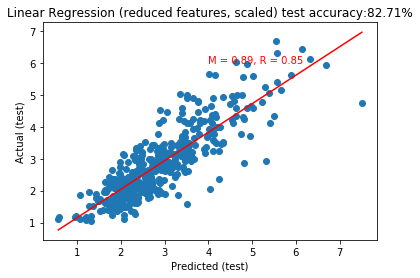

Linear Regression (reduced features, scaled) accuracy: 81.22 %.


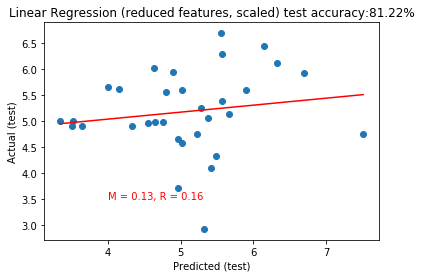

In [41]:
# Create linear regression model
LRmodel_scaled_20 = LinearRegression(fit_intercept = True, normalize = True)
LRmodel_scaled_20.fit(X_train_scaled_20, y_train)

r2 = LRmodel_scaled_20.score(X_train_scaled_20, y_train)
print('LR coefficient of determination (features=', X_20.shape[1],')',round(r2,4))

# Generate predictions and assess accuracy
LR_pred_scaled_20 = LRmodel_scaled_20.predict(X_test_scaled_20)
LRerrors = abs(LR_pred_scaled_20 - y_test)

# Calculate mean absolute percentage error (MAPE)
LRmape = 100 * (LRerrors / y_test)
LRaccuracy = 100 - np.mean(LRmape)

# Assess predicted and actal
LR_string = 'Linear Regression (reduced features, scaled)'
plot_predicted_actual(LR_pred_scaled_20, LR_string, LRaccuracy)

# Assess performance against high priority predictions
assessPriorityPredictions(LR_pred_scaled_20, LR_string, combined_priority)    

### Random Forest Regression

In [42]:
#### Function to undertake Random Forest Regression
def RF_analysis(X_train_var, X_test_var, y_train_var, y_test_var, model_string, num_trees_var):

    # Instantiate model with num_trees decision trees
    RFmodel = RandomForestRegressor(n_estimators = num_trees_var, oob_score = True, random_state = random_state)

    # Train the model on training data
    RFmodel.fit(X_train_var, y_train_var)

    # Generate predictions to assess performance
    RF_pred = RFmodel.predict(X_test_var)# Calculate the absolute errors
    RFerrors = abs(RF_pred - y_test_var)

    # Calculate mean absolute percentage error (MAPE)
    RFmape = 100 * (RFerrors / y_test_var)
    RFaccuracy = 100 - np.mean(RFmape)
    print(model_string, round(RFaccuracy, 2), '%.')
    RFtest_score = RFmodel.score(X_test_var, y_test_var)
    print('RF test score:', round(RFtest_score, 3))
    print('Out of bag score:', round(RFmodel.oob_score_,4))

    # Assess predicted and actal
    plot_predicted_actual(RF_pred, model_string, RFaccuracy)

    # Assess performance against high priority predictions
    assessPriorityPredictions(RF_pred, model_string, combined_priority)

In [43]:
#### Function to perform 10-fold Cross Validation using RF
def CV_RF(X_train_var, X_var, model_string, num_trees_var):
    k_folds = 10

    # Instantiate model with num_trees decision trees
    RFmodel_CV = RandomForestRegressor(n_estimators = num_trees_var, oob_score = True, random_state = random_state)

    # Train the model on training data
    RFmodel_CV.fit(X_train_var, y_train)

    RFscores = cross_val_score(RFmodel_CV, X_var, y, cv=k_folds)
    print(model_string,k_folds,'fold CV average score:', round(np.mean(RFscores)*100,2),'%')

Random Forest (all features, unscaled) 85.42 %.
RF test score: 0.777
Out of bag score: 0.8055


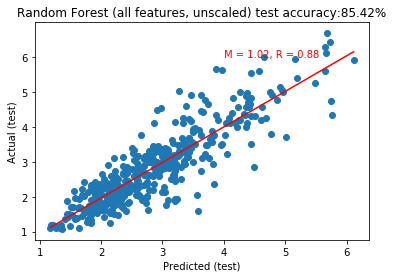

Random Forest (all features, unscaled) accuracy: 84.75 %.


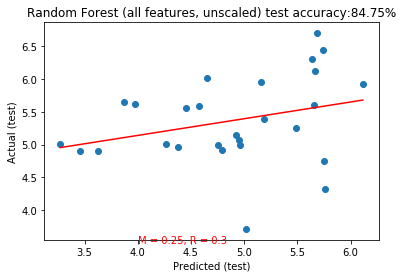

In [44]:
# RF unscaled, all features
RF_analysis(X_train, X_test, y_train, y_test, 'Random Forest (all features, unscaled)', 1000)

Random Forest (all features, scaled) 85.2 %.
RF test score: 0.776
Out of bag score: 0.8056


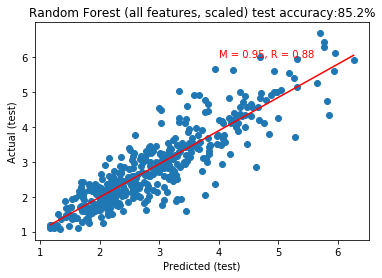

Random Forest (all features, scaled) accuracy: 86.03 %.


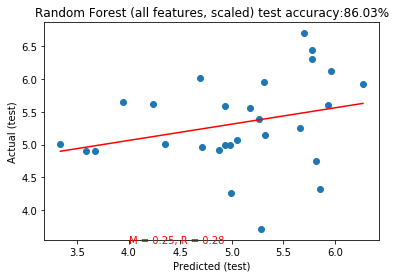

In [45]:
# RF scaled, all features
RF_analysis(X_train_scaled, X_test_scaled, y_train, y_test, 'Random Forest (all features, scaled)', 1000)

Random Forest (reduced features 20, unscaled) 85.09 %.
RF test score: 0.769
Out of bag score: 0.8019


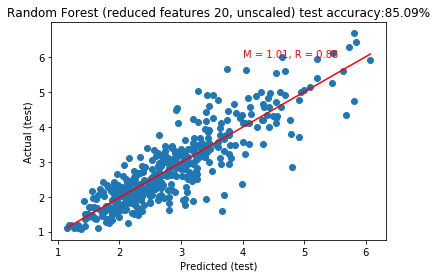

Random Forest (reduced features 20, unscaled) accuracy: 85.51 %.


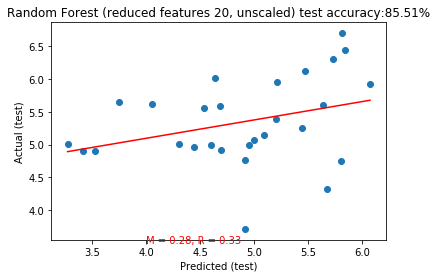

In [46]:
# RF unscaled, reduced features 20
RF_analysis(X_train_20, X_test_20, y_train, y_test,'Random Forest (reduced features 20, unscaled)', 1000)

Random Forest (reduced features 9, unscaled) 84.35 %.
RF test score: 0.75
Out of bag score: 0.7777


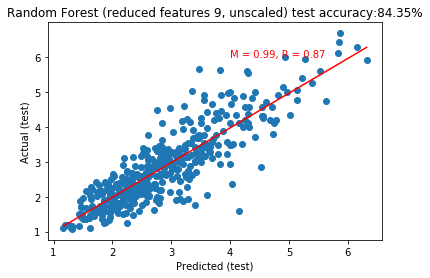

Random Forest (reduced features 9, unscaled) accuracy: 86.2 %.


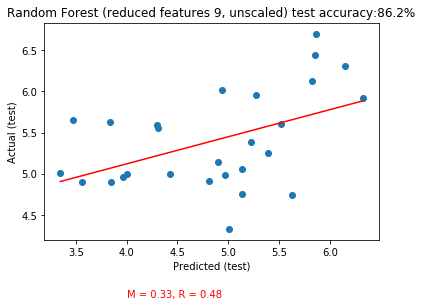

In [47]:
# RF unscaled, reduce features 9
RF_analysis(X_train_9, X_test_9, y_train, y_test,'Random Forest (reduced features 9, unscaled)', 1000)

Random Forest (reduced features OLS, unscaled) 85.06 %.
RF test score: 0.764
Out of bag score: 0.7975


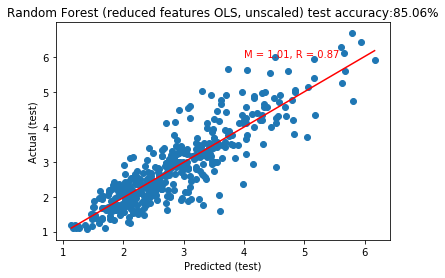

Random Forest (reduced features OLS, unscaled) accuracy: 84.39 %.


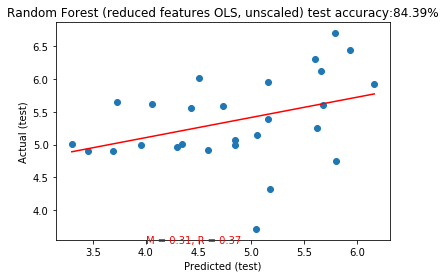

In [48]:
# RF unscaled, OLS features
RF_analysis(X_train_OLS, X_test_OLS, y_train, y_test,'Random Forest (reduced features OLS, unscaled)', 1000)

#### Cross validation score

In [49]:
# Cross validation using small feature set
CV_RF(X_train_9, X_9, 'RF CV reduced features', 1000)

RF CV reduced features 10 fold CV average score: 41.22 %


#### Investigate performance predicting sub-measures (eg Twist3)

RF prediction T3 (all features, unscaled) 81.3 %.
RF test score: 0.696
Out of bag score: 0.7738


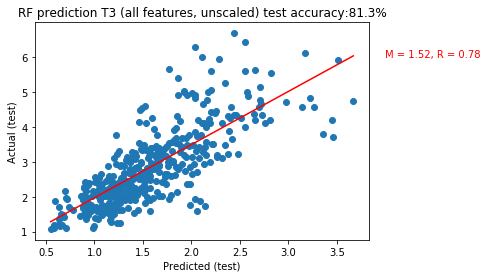

RF prediction T3 (all features, unscaled) accuracy: 42.24 %.


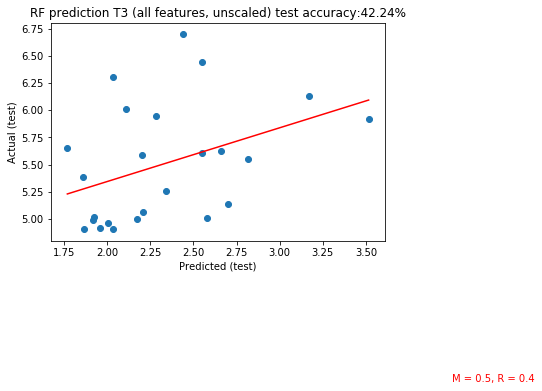

In [50]:
# RF unscaled, all features
RF_analysis(X_train, X_test, y_trainT3, y_testT3, 'RF prediction T3 (all features, unscaled)', 1000)

RF prediction TL (all features, unscaled) 78.85 %.
RF test score: 0.714
Out of bag score: 0.7145


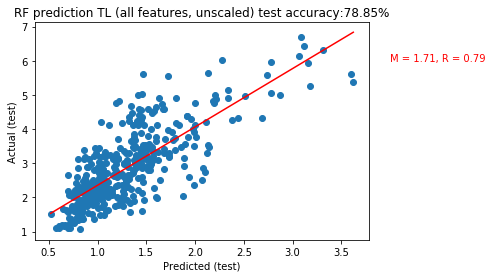

RF prediction TL (all features, unscaled) accuracy: 45.75 %.


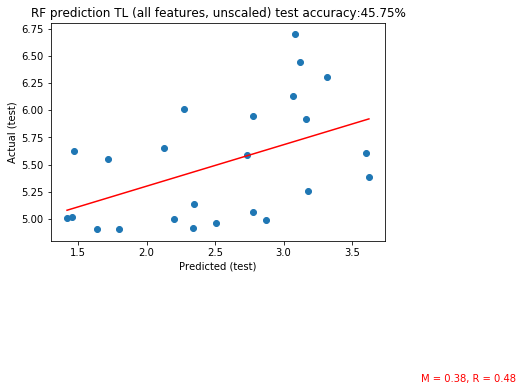

In [51]:
# RF unscaled, all features
RF_analysis(X_train, X_test, y_trainTL, y_testTL, 'RF prediction TL (all features, unscaled)', 1000)

RF prediction TR (all features, unscaled) 79.03 %.
RF test score: 0.729
Out of bag score: 0.7408


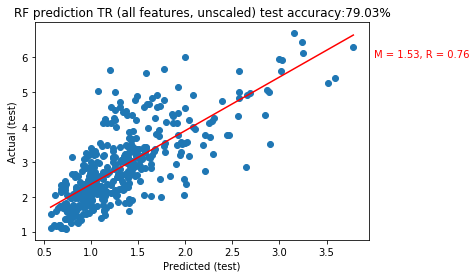

RF prediction TR (all features, unscaled) accuracy: 45.63 %.


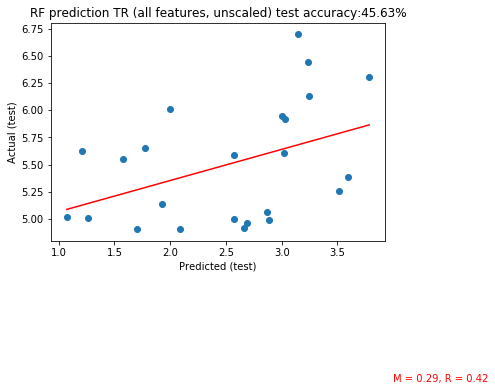

In [52]:
# RF unscaled, all features
RF_analysis(X_train, X_test, y_trainTR, y_testTR, 'RF prediction TR (all features, unscaled)', 1000)

### Support Vector Regression

In [53]:
#### Function to fit and test SVR
def SVR_analysis(X_train_var, X_test_var, model_string, kernel_var, C_var, epsilon_var, plot_option, poly_degree):
    SVRmodel = SVR(C=C_var, kernel=kernel_var, gamma='auto', epsilon=epsilon_var, degree=poly_degree)
    SVRmodel.fit(X_train_var,y_train)

    # Generate predictions to plot predicted and actuals
    SVR_pred = SVRmodel.predict(X_test_var)

    # Assess accuracy
    SVRerrors = abs(SVR_pred - y_test)

    # Calculate mean absolute percentage error (MAPE)
    SVRmape = 100 * (SVRerrors / y_test)
    SVRaccuracy = 100 - np.mean(SVRmape)
    print('SVR accuracy:', round(SVRaccuracy, 2), '%.')
    SVRtest_score = SVRmodel.score(X_test_var, y_test)
    print('SVR test score:', round(SVRtest_score, 3))

    if plot_option:
        # Assess predicted and actal
        plot_predicted_actual(SVR_pred, model_string, SVRaccuracy)

        # Assess performance against high priority predictions
        assessPriorityPredictions(SVR_pred, SVR_string, combined_priority)
        
    return SVRaccuracy, SVRtest_score    

#### RBF Kernel

In [54]:
# Vary C to optimise SVR NB C=0 = no penalty
C_array = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]
SVR_array = [] # array will store C, test accuracy and test score

for C_iter in C_array:
    print('\nC:', C_iter)
    SVRaccuracy, SVRtest_score = SVR_analysis(X_train_scaled, X_test_scaled, 'N/A', 'rbf', C_iter, 0.01, 
                                              plot_option=False, poly_degree=0)
    SVR_array.append([C_iter, SVRaccuracy, SVRtest_score])

SVR_array = np.asarray(SVR_array)    


C: 0.001
SVR accuracy: 68.5 %.
SVR test score: -0.009

C: 0.01
SVR accuracy: 72.02 %.
SVR test score: 0.185

C: 0.1
SVR accuracy: 80.68 %.
SVR test score: 0.547

C: 1.0
SVR accuracy: 84.17 %.
SVR test score: 0.711

C: 10
SVR accuracy: 84.8 %.
SVR test score: 0.755

C: 100
SVR accuracy: 82.89 %.
SVR test score: 0.707

C: 1000
SVR accuracy: 82.77 %.
SVR test score: 0.705


SVR accuracy: 84.8 %.
SVR test score: 0.755


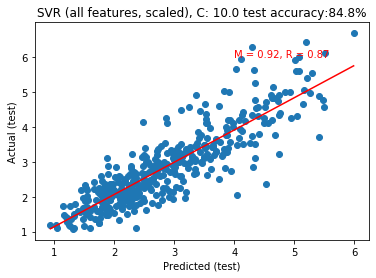

SVR (all features, scaled), C: 10.0 accuracy: 84.7 %.


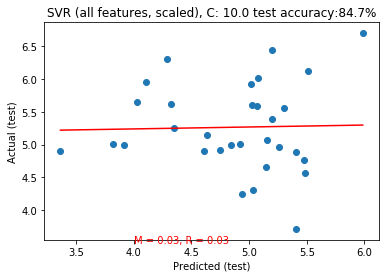

In [55]:
# Refit using optimal params, all features
SVR_best_C = SVR_array[np.where(SVR_array[:,1] == np.max(SVR_array[:,1]))[0][0], 0]
SVR_best_epsilon = 0.001

# Assess model
SVR_string = 'SVR (all features, scaled), C: ' + str(SVR_best_C)
SVRaccuracy, SVRtest_score = SVR_analysis(X_train_scaled, X_test_scaled, SVR_string, 'rbf', SVR_best_C, 
                                          0.01, plot_option=True, poly_degree=0)

SVR accuracy: 82.9 %.
SVR test score: 0.7


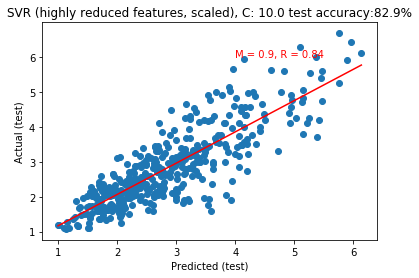

SVR (highly reduced features, scaled), C: 10.0 accuracy: 84.44 %.


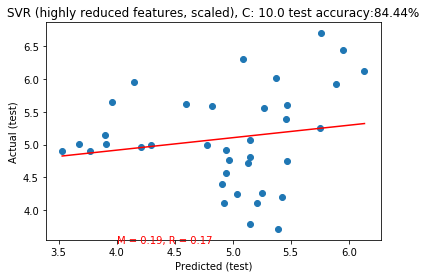

In [56]:
# Refit using optimal params, reduced features 9
SVR_string = 'SVR (highly reduced features, scaled), C: ' + str(SVR_best_C)
SVRaccuracy, SVRtest_score = SVR_analysis(X_train_scaled_9, X_test_scaled_9, SVR_string, 'rbf', SVR_best_C, 
                                          0.01, plot_option=True, poly_degree=0)

SVR accuracy: 85.14 %.
SVR test score: 0.756


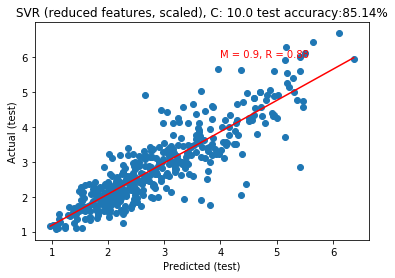

SVR (reduced features, scaled), C: 10.0 accuracy: 85.25 %.


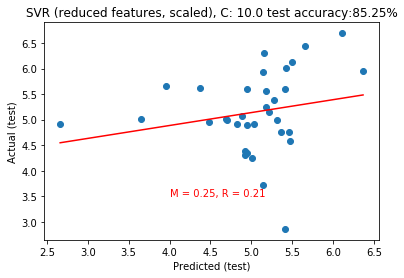

In [57]:
# Refit using optimal params, reduced features 20
SVR_string = 'SVR (reduced features, scaled), C: ' + str(SVR_best_C)
SVRaccuracy, SVRtest_score = SVR_analysis(X_train_scaled_20, X_test_scaled_20, SVR_string, 'rbf', SVR_best_C, 
                                          0.01, plot_option=True, poly_degree=0)

SVR accuracy: 83.29 %.
SVR test score: 0.732


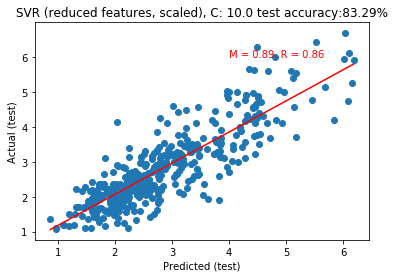

SVR (reduced features, scaled), C: 10.0 accuracy: 84.72 %.


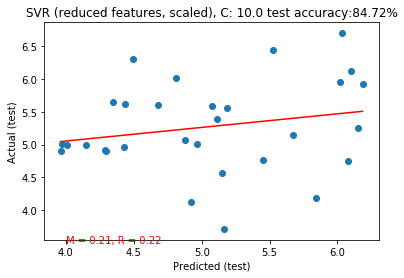

In [58]:
# Refit using OLS params
SVR_string = 'SVR (reduced features, scaled), C: ' + str(SVR_best_C)
SVRaccuracy, SVRtest_score = SVR_analysis(X_train_scaled_OLS, X_test_scaled_OLS, SVR_string, 'rbf', SVR_best_C, 
                                          0.01, plot_option=True, poly_degree=0)

#### Sigmoid Kernel

In [59]:
# Vary C to optimise SVR NB C=0 = no penalty
C_array = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]
SVR_array = [] # array will store C, test accuracy and test score

for C_iter in C_array:
    print('\nC:', C_iter)
    SVRaccuracy, SVRtest_score = SVR_analysis(X_train_scaled, X_test_scaled, 'N/A', 'sigmoid', C_iter, 0.01, 
                                              plot_option=False, poly_degree=0)
    SVR_array.append([C_iter, SVRaccuracy, SVRtest_score])

SVR_array = np.asarray(SVR_array)    


C: 0.001
SVR accuracy: 69.28 %.
SVR test score: 0.049

C: 0.01
SVR accuracy: 76.73 %.
SVR test score: 0.452

C: 0.1
SVR accuracy: 77.11 %.
SVR test score: 0.318

C: 1.0
SVR accuracy: -14.41 %.
SVR test score: -68.693

C: 10
SVR accuracy: -995.61 %.
SVR test score: -7738.621

C: 100
SVR accuracy: -11176.94 %.
SVR test score: -795608.152

C: 1000
SVR accuracy: -112776.73 %.
SVR test score: -81620662.086


#### Polynomial Kernel

In [60]:
# Vary C to optimise SVR NB C=0 = no penalty
C_array = [0.001, 0.01, 0.1, 1.0, 10, 100, 1000]
SVR_array = [] # array will store C, test accuracy and test score

for C_iter in C_array:
    print('\nC:', C_iter)
    SVRaccuracy, SVRtest_score = SVR_analysis(X_train_scaled, X_test_scaled, 'N/A', 'poly', C_iter, 0.01, 
                                              plot_option=False, poly_degree=4)
    SVR_array.append([C_iter, SVRaccuracy, SVRtest_score])

SVR_array = np.asarray(SVR_array)    


C: 0.001
SVR accuracy: 69.68 %.
SVR test score: 0.088

C: 0.01
SVR accuracy: 71.02 %.
SVR test score: 0.18

C: 0.1
SVR accuracy: 73.42 %.
SVR test score: 0.326

C: 1.0
SVR accuracy: 75.2 %.
SVR test score: -0.252

C: 10
SVR accuracy: 72.16 %.
SVR test score: -13.1

C: 100
SVR accuracy: 64.59 %.
SVR test score: -31.426

C: 1000
SVR accuracy: 55.33 %.
SVR test score: -46.709


### KNN

#### NB given use of distance metrics, KNN must use scaled data

In [61]:
#### Functin to find optimal parameters given , y
def KNN_optimal_params(X_var, y_var):
    # Find optimal KNN params
    GS_CV = 10 # K-fold CV
    K_min = 5 # Min K value
    K_max = 50 # Max K value
    K_inc = 5 # Increment in K search

    KNNgrid_params = {
        'n_neighbors': np.array(range(K_min,K_max,K_inc)),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],
        'p': [1, 2, 3, 1000] }

    KNNsearch = GridSearchCV(neighbors.KNeighborsRegressor(), KNNgrid_params, cv=GS_CV)
    KNNsearch.fit(X_var, y_var)
    print('Optimal KNN paramaters:', KNNsearch.best_params_)

    return KNNsearch

In [62]:
# Obtain optimal parameters
KNNsearch_var = KNN_optimal_params(X_train_scaled, y_train)

# Extract optimal parameters
KNNopt_algorithm = KNNsearch_var.best_params_['algorithm']
KNNopt_metric = KNNsearch_var.best_params_['metric']
KNNopt_n_neighbors = KNNsearch_var.best_params_['n_neighbors']
KNNopt_p = KNNsearch_var.best_params_['p']
KNNopt_weights = KNNsearch_var.best_params_['weights']

Optimal KNN paramaters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


In [63]:
#### Function for fitting and assessing a KNN Regression model
def KNN_analysis(X_train_var, X_test_var, model_string):
    KNNrmse_array = [] # to store rmse values for different k
    K_min = 5 # Min K value
    K_max = 250 # Max K value
    K_inc = 5 # Increment in K search

    for K in range(K_min, K_max, K_inc):
        # Use global variables established for optimal params
        KNNmodel = neighbors.KNeighborsRegressor(algorithm = KNNopt_algorithm, metric=KNNopt_metric, 
                                            n_neighbors = K, p=KNNopt_p, weights=KNNopt_weights)

        KNNmodel.fit(X_train_var, y_train)  #fit the model
        KNNpred = KNNmodel.predict(X_test_var) #make prediction on test set
        KNNrmse = (mean_squared_error(y_test, KNNpred))**0.5 #calculate rmse
        KNNrmse_array.append([K,KNNrmse]) #store rmse values

    # Plot RMSE vs. K
    KNNelbow = pd.DataFrame(KNNrmse_array) #elbow curve 
    plt.plot(KNNelbow.loc[:,0], KNNelbow.loc[:,1], '.b-')
    title_text = model_string + ' Test error vs. K' 
    plt.title(title_text)
    plt.xlabel('K')
    plt.ylabel('Test RMSE')
    ax = plt.gca()
    plt.show()
    
    # Extract optimal K
    KNN_opt_ix = KNNelbow.loc[:,1].idxmin(axis=1)
    K_opt = KNNelbow.iloc[KNN_opt_ix, 0]

    # Refit using optimal K
    KNNmodel = neighbors.KNeighborsRegressor(n_neighbors = K_opt)
    KNNmodel.fit(X_train_var, y_train)  #fit the model

    # Generate predictions to plot predicted and actuals
    KNN_pred = KNNmodel.predict(X_test_var)
    KNNerrors = abs(KNN_pred - y_test)

    # Calculate mean absolute percentage error (MAPE)
    KNNmape = 100 * (KNNerrors / y_test)
    KNNaccuracy = 100 - np.mean(KNNmape)
    print('Optimal K:', K_opt)
    print('KNN accuracy (features=', X_train_var.shape[1],'):', round(KNNaccuracy, 2), '%.')
    KNNtest_score = KNNmodel.score(X_test_var, y_test)
    print('KNN test score:', round(KNNtest_score, 3))

    # Assess predicted and actual
    KNN_string = model_string + ' K=' +str(K_opt)
    plot_predicted_actual(KNN_pred, KNN_string, KNNaccuracy)

    # Assess performance against high priority predictions
    assessPriorityPredictions(KNN_pred, KNN_string, combined_priority)

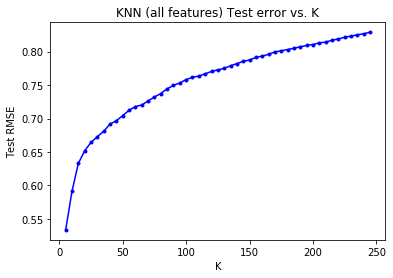

Optimal K: 5
KNN accuracy (features= 46 ): 81.68 %.
KNN test score: 0.652


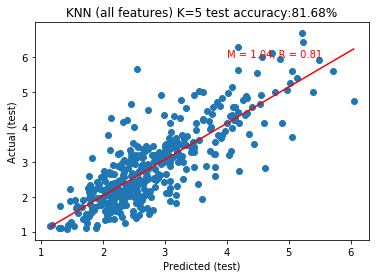

KNN (all features) K=5 accuracy: 80.08 %.


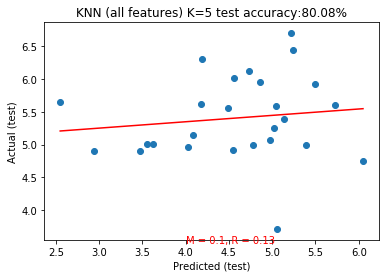

In [64]:
# Perform on full scaled features
KNN_analysis(X_train_scaled, X_test_scaled, 'KNN (all features)')

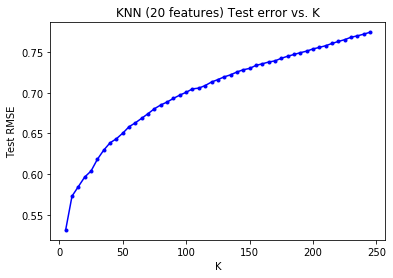

Optimal K: 5
KNN accuracy (features= 20 ): 83.33 %.
KNN test score: 0.698


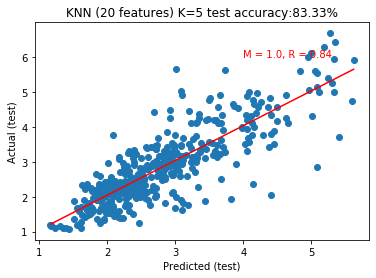

KNN (20 features) K=5 accuracy: 80.93 %.


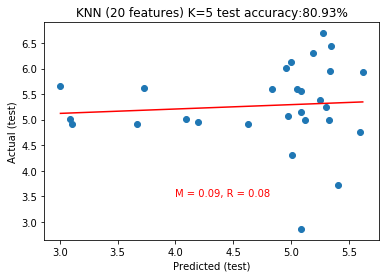

In [65]:
# Perform on reduced scaled features 20
KNN_analysis(X_train_scaled_20, X_test_scaled_20, 'KNN (20 features)')

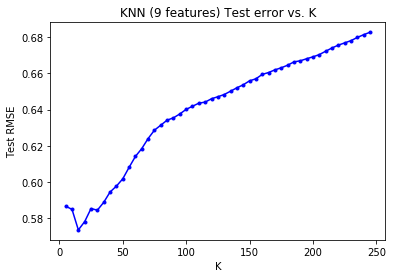

Optimal K: 15
KNN accuracy (features= 9 ): 82.21 %.
KNN test score: 0.678


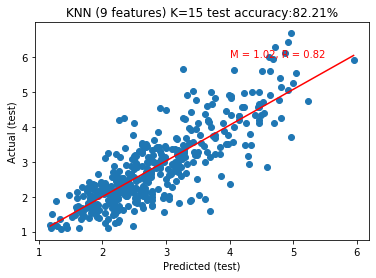

KNN (9 features) K=15 accuracy: 81.64 %.


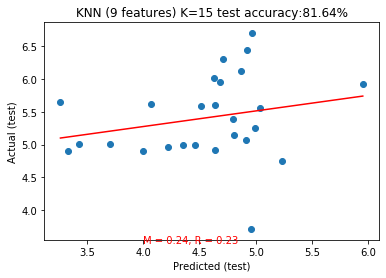

In [66]:
# Perform on reduced scaled features 9
KNN_analysis(X_train_scaled_9, X_test_scaled_9, 'KNN (9 features)')

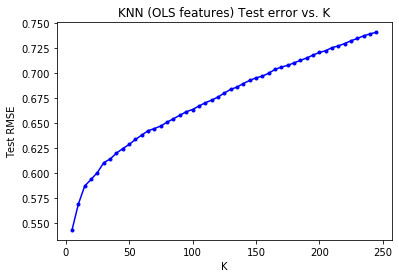

Optimal K: 5
KNN accuracy (features= 19 ): 83.59 %.
KNN test score: 0.714


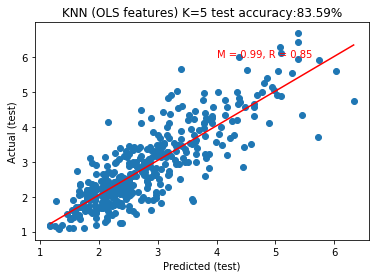

KNN (OLS features) K=5 accuracy: 83.19 %.


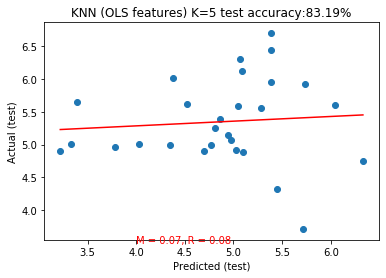

In [67]:
# Perform on reduced scaled features OLS
KNN_analysis(X_train_scaled_OLS, X_test_scaled_OLS, 'KNN (OLS features)')

### Artificial Neural Network

#### KerasRegressor

In [68]:
# Establish global variable to build base model
ANN_inputs = 0

In [111]:
#### Function to specify a Sequential ANN
# Specify the keras model
# Cannot pass variable to build model therefore reference global variable
def ANNbase_model():
    ANNmodel = Sequential()
    ANNmodel.add(Dense(256, input_dim=ANN_inputs, activation='relu'))
    ANNmodel.add(Dense(128, kernel_initializer='random_uniform',bias_initializer='zeros', activation='relu'))
    ANNmodel.add(Dense(64, kernel_initializer='random_uniform',bias_initializer='zeros', activation='relu'))
    ANNmodel.add(Dense(32, kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu'))
    ANNmodel.add(Dense(16, kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu'))
    ANNmodel.add(Dense(8, kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu'))
    ANNmodel.add(Dense(4, kernel_initializer='random_uniform',bias_initializer='zeros',activation='relu'))
    ANNmodel.add(Dense(1, activation='linear')) 

    # compile the keras model
    ANNmodel.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['accuracy'])
    
    return ANNmodel

In [112]:
#### Function to implement and assess KerasRegressor
def KerasRegressor_analysis(X_train_var, X_test_var, model_string, CV_option):
    # Evalate ANN using CV
    # Key variables
    n_epochs = 1000 # iterations
    # Smaller batches enable the ANN to better generalise
    # Too small batches mean weights are updated based on data that may not be representative 
    ANNbatch = 25 # batches of training samples to propogate to optimise memory
    ANN_CV = 10 #kfold CV

    global ANN_inputs # Register as global variable to be accessed by ANN build function
    
    if CV_option: # CV to be performed using full, scaled training set
        ANN_inputs = X_scaled.shape[1]
        ANNestimator = KerasRegressor(build_fn=ANNbase_model, epochs=n_epochs, 
                                      batch_size=ANNbatch, verbose=0)
        ANNkfold = KFold(n_splits=ANN_CV)
        ANNresults = cross_val_score(ANNestimator, X_scaled, y, cv=ANNkfold)
        print("Baseline: %.2f (%.2f) MSE" % (ANNresults.mean(), ANNresults.std()))

    # Fit using training set
    ANN_inputs = X_train_var.shape[1]
    ANNestimator = KerasRegressor(build_fn=ANNbase_model, epochs=n_epochs, 
                                  batch_size=ANNbatch, verbose=0)
    
    print(ANNestimator, X_train_var.shape[1])
    ANNestimator.fit(X_train_var, y_train)
    ANN_pred = ANNestimator.predict(X_test_var)
    ANNerrors = abs(ANN_pred - y_test)

    # Calculate mean absolute percentage error (MAPE)
    ANNmape = 100 * (ANNerrors / y_test)
    ANNaccuracy = 100 - np.mean(ANNmape)
    print('ANN accuracy (features=', X_train_var.shape[1],'):', round(ANNaccuracy, 2), '%.')
    ANNtest_score = ANNestimator.score(X_test_var, y_test)
    print('ANN test score:', round(ANNtest_score, 3),'% MAPE')

    # Assess predicted and actual
    plot_predicted_actual(ANN_pred, model_string, ANNaccuracy)

    # Assess performance against high priority predictions
    assessPriorityPredictions(ANN_pred, model_string, combined_priority)

In [69]:
#### Function implements Keras Sequential ANN with early stopping
def ANNes_analysis(X_train_var, X_test_var, y_train_var, y_test_var, model_string):
    # Key variables
    es_baseline = 0.0 # do not consider stopping until this level of MAPE achieved
    es_epochs = 1000
    ANNpatience = es_epochs*0.25 

    # Configure optimizer
    ANNadam = optimizers.Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.999, amsgrad=False)
    # default Adam: Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

    # Establish ANN
    ANNmodel = Sequential()
    ANNmodel.add(Dense(256, input_dim=X_train_var.shape[1], activation='relu'))
    ANNmodel.add(Dense(128, kernel_initializer='random_uniform',bias_initializer='ones', activation='relu'))
    ANNmodel.add(Dense(64, kernel_initializer='random_uniform',bias_initializer='ones', activation='relu'))
    ANNmodel.add(Dense(32, kernel_initializer='random_uniform',bias_initializer='ones',activation='relu'))
    ANNmodel.add(Dense(16, kernel_initializer='random_uniform',bias_initializer='ones',activation='relu'))
    ANNmodel.add(Dense(8, kernel_initializer='random_uniform',bias_initializer='ones',activation='relu'))
    ANNmodel.add(Dense(4, kernel_initializer='random_uniform',bias_initializer='ones',activation='relu'))
    ANNmodel.add(Dense(1, activation='linear')) 

    # compile the keras model
    ANNmodel.compile(loss='mean_absolute_percentage_error', optimizer=ANNadam, metrics=['accuracy'])

    # Establish early stopping criteria
    ANNes = EarlyStopping(monitor='val_loss', mode='min', min_delta=0,  verbose=0, baseline=es_baseline,
                          patience=ANNpatience)
    ANNmc = ModelCheckpoint('ANNmodel_opt.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    # Fit model
    ANNhistory = ANNmodel.fit(X_train_var, y_train_var, validation_data=(X_test_var, y_test_var), 
                                  epochs=es_epochs, verbose=0, callbacks=[ANNes, ANNmc])

    # Load the optimal model
    ANNmodel_opt = load_model('ANNmodel_opt.h5')

    # Plot ANN training history
    plt.plot(ANNhistory.history['loss'], label='train')
    plt.plot(ANNhistory.history['val_loss'], label='test')
    plt.title('ANN loss versus epoch', fontsize=12)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.show()

    # Evaluate training and test acuracy
    ANN_pred = ANNmodel_opt.predict(X_test_var).reshape((-1,))
    ANNerrors = abs(ANN_pred - y_test_var)

    # Calculate mean absolute percentage error (MAPE)
    ANNmape = 100 * (ANNerrors / y_test_var)
    ANNaccuracy = 100 - np.mean(ANNmape)
    print('ANN accuracy (features=', X_train_var.shape[1],'):', round(ANNaccuracy, 2), '%.')

    # Assess predicted and actual
    plot_predicted_actual(ANN_pred, model_string, ANNaccuracy)

    # Assess performance against high priority predictions
    assessPriorityPredictions(ANN_pred, model_string, combined_priority)

Baseline: -23.35 (5.01) MSE
ANN accuracy (features= 46 ): 85.12 %.
ANN test score: -14.882 % MAPE


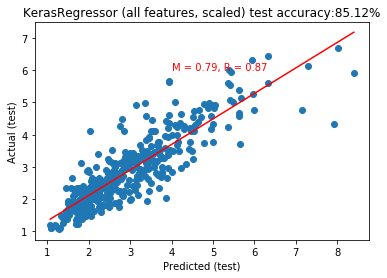

KerasRegressor (all features, scaled) accuracy: 81.3 %.


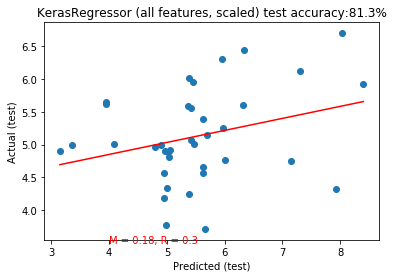

In [79]:
# KerasRegressor using all features and initial CV
KerasRegressor_analysis(X_train_scaled, X_test_scaled, 'KerasRegressor (all features, scaled)', CV_option=True)

<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002F7F9526608> 20
ANN accuracy (features= 20 ): 84.45 %.
ANN test score: -15.553 % MAPE


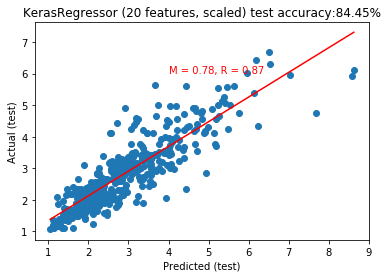

KerasRegressor (20 features, scaled) accuracy: 80.42 %.


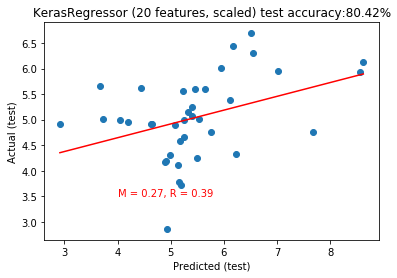

In [113]:
# KerasRegressor using 20 features without CV
KerasRegressor_analysis(X_train_scaled_20, X_test_scaled_20, 'KerasRegressor (20 features, scaled)', CV_option=False)

<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002F7F43ED588> 9
ANN accuracy (features= 9 ): 81.65 %.
ANN test score: -18.354 % MAPE


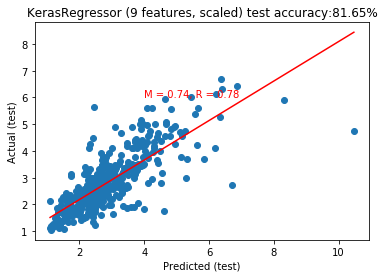

KerasRegressor (9 features, scaled) accuracy: 72.42 %.


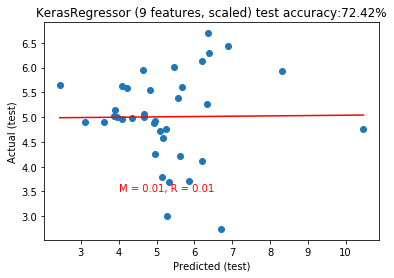

In [114]:
# KerasRegressor using 9 features without CV
KerasRegressor_analysis(X_train_scaled_9, X_test_scaled_9, 'KerasRegressor (9 features, scaled)', CV_option=False)

<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002F7F9206E48> 19
ANN accuracy (features= 19 ): 83.95 %.
ANN test score: -16.049 % MAPE


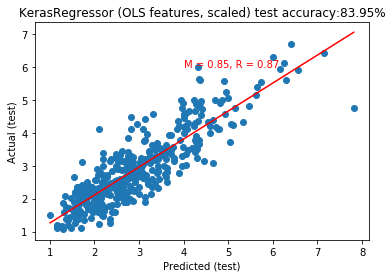

KerasRegressor (OLS features, scaled) accuracy: 86.28 %.


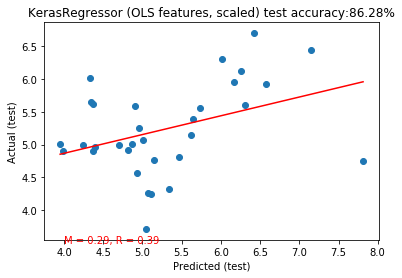

In [115]:
# KerasRegressor using OLS features without CV
KerasRegressor_analysis(X_train_scaled_OLS, X_test_scaled_OLS, 'KerasRegressor (OLS features, scaled)', CV_option=False)

#### Implement early stopping

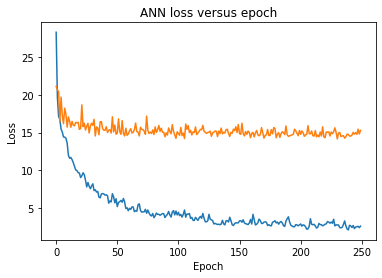

ANN accuracy (features= 46 ): 85.84 %.


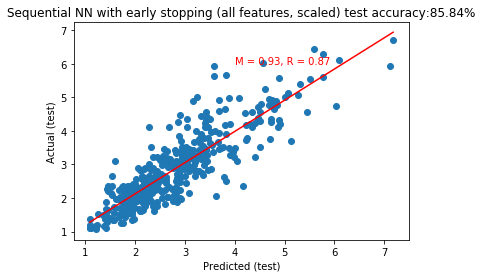

Sequential NN with early stopping (all features, scaled) accuracy: 83.41 %.


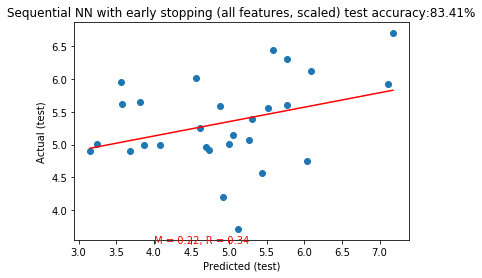

In [70]:
# All features, scaled
ANN_string = 'Sequential NN with early stopping (all features, scaled)'
ANNes_analysis(X_train_scaled, X_test_scaled, y_train, y_test, ANN_string)

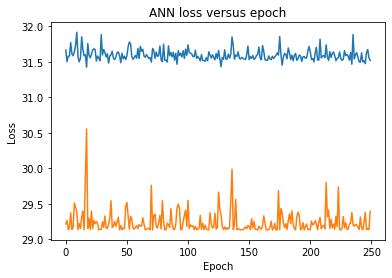

ANN accuracy (features= 20 ): 70.87 %.


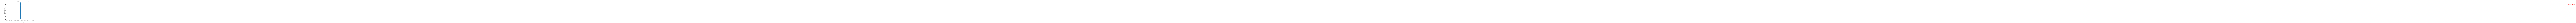

Sequential NN with early stopping (20 features, scaled) accuracy: 40.79 %.


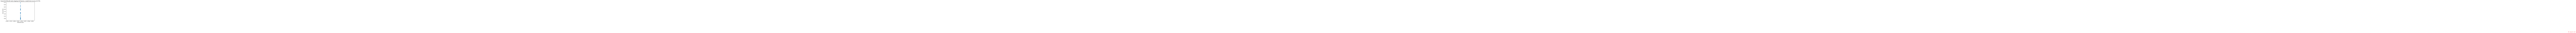

In [71]:
# 20 features, scaled
ANN_string = 'Sequential NN with early stopping (20 features, scaled)'
ANNes_analysis(X_train_scaled_20, X_test_scaled_20, y_train, y_test, ANN_string)

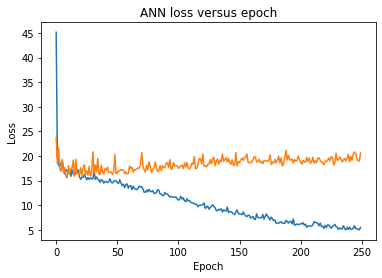

ANN accuracy (features= 9 ): 84.4 %.


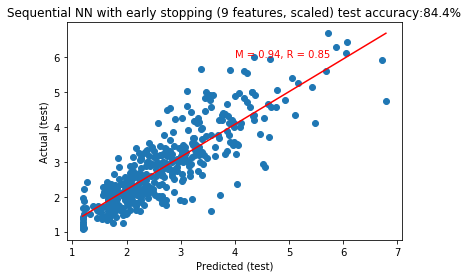

Sequential NN with early stopping (9 features, scaled) accuracy: 81.86 %.


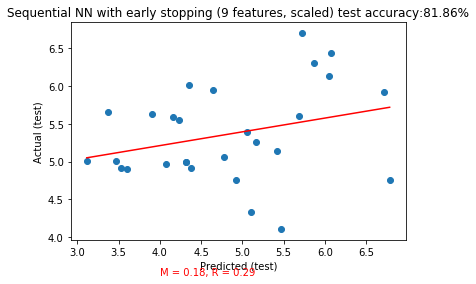

In [72]:
# 9 features, scaled
ANN_string = 'Sequential NN with early stopping (9 features, scaled)'
ANNes_analysis(X_train_scaled_9, X_test_scaled_9, y_train, y_test, ANN_string)

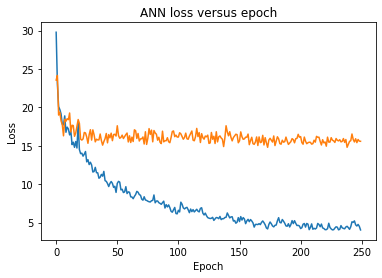

ANN accuracy (features= 19 ): 85.21 %.


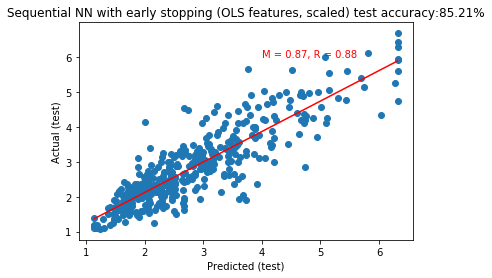

Sequential NN with early stopping (OLS features, scaled) accuracy: 86.88 %.


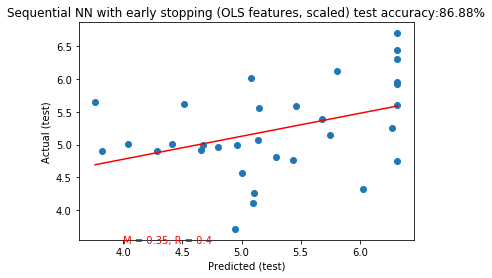

In [73]:
# OLS features, scaled
ANN_string = 'Sequential NN with early stopping (OLS features, scaled)'
ANNes_analysis(X_train_scaled_OLS, X_test_scaled_OLS, y_train, y_test, ANN_string)

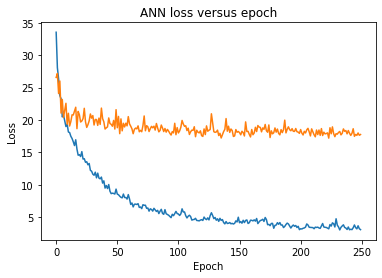

ANN accuracy (features= 20 ): 82.79 %.


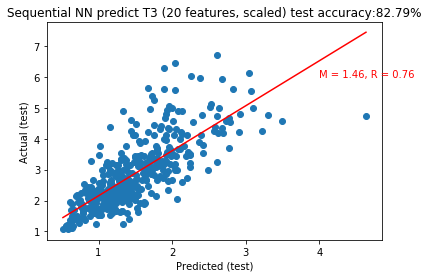

Sequential NN predict T3 (20 features, scaled) accuracy: 40.78 %.


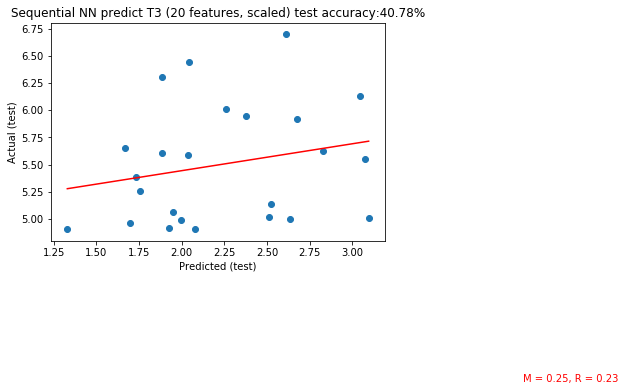

In [74]:
# Predict sub-features (T3, TL and TR)
ANN_string = 'Sequential NN predict T3 (20 features, scaled)'
ANNes_analysis(X_train_scaled_20, X_test_scaled_20, y_trainT3, y_testT3, ANN_string)

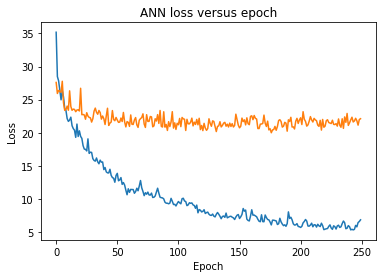

ANN accuracy (features= 20 ): 79.99 %.


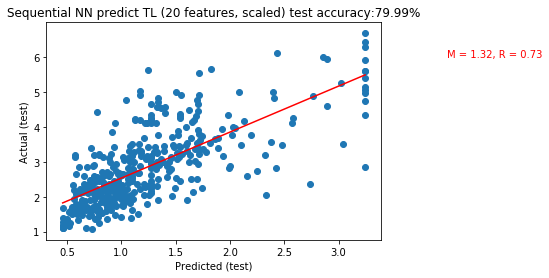

Sequential NN predict TL (20 features, scaled) accuracy: 45.24 %.


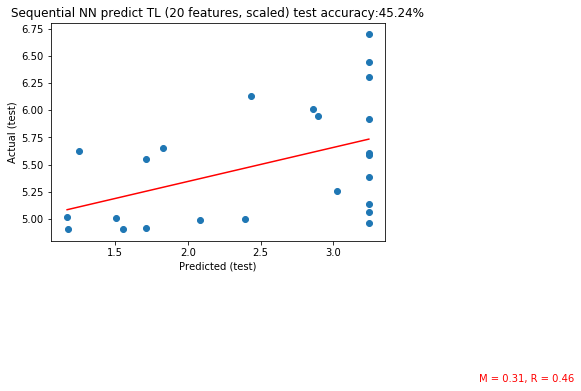

In [75]:
# Predict sub-features (T3, TL and TR)
ANN_string = 'Sequential NN predict TL (20 features, scaled)'
ANNes_analysis(X_train_scaled_20, X_test_scaled_20, y_trainTL, y_testTL, ANN_string)

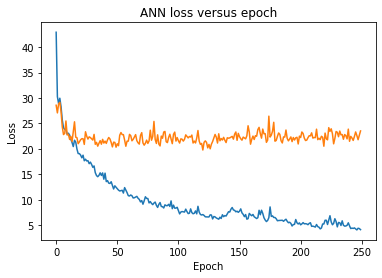

ANN accuracy (features= 20 ): 80.22 %.


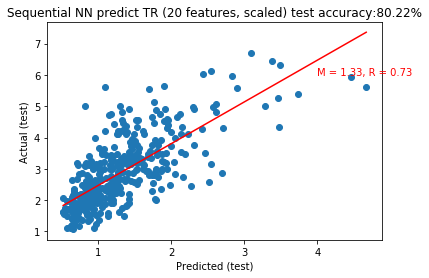

Sequential NN predict TR (20 features, scaled) accuracy: 46.62 %.


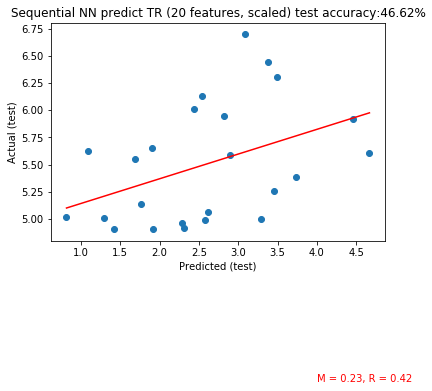

In [76]:
# Predict sub-features (T3, TL and TR)
ANN_string = 'Sequential NN predict TR (20 features, scaled)'
ANNes_analysis(X_train_scaled_20, X_test_scaled_20, y_trainTR, y_testTR, ANN_string)

### MLP

In [129]:
#### Function to implement and assess MLP
def MLP_analysis(X_train_var, X_test_var, model_string):
    # Define MLP
    MLPbatch = 25
    MLPalpha = 1e-2 # L2 regularization
    max_iter = 10000 # Maximum number of iterations
    n_iter_no_change = max(25, max_iter/100)
    
    MLPmodel = MLPRegressor(hidden_layer_sizes=(256, 128, 64, 32, 16, 8, 4, 1), activation= 'relu', solver= 'adam', 
                    alpha=MLPalpha, batch_size= MLPbatch, learning_rate= 'invscaling', max_iter=max_iter, 
                    shuffle=True, random_state=None, tol=1e-4, verbose=False, warm_start=True, early_stopping=True, 
                    validation_fraction=0.2, epsilon=1e-6, n_iter_no_change=n_iter_no_change)

    MLPmodel.fit(X_train_var, y_train)
    MLP_pred = MLPmodel.predict(X_test_var)
    MLPerrors = abs(MLP_pred - y_test)

    # Calculate mean absolute percentage error (MAPE)
    MLPmape = 100 * (MLPerrors / y_test)
    MLPaccuracy = 100 - np.mean(MLPmape)
    print('MLP accuracy (features=', X_train_var.shape[1],'):', round(MLPaccuracy, 2), '%.')
    MLPtest_score = MLPmodel.score(X_test_var, y_test)
    print('MLP test score:', round(MLPtest_score, 3))

    # Assess predicted and actual
    plot_predicted_actual(MLP_pred, model_string, MLPaccuracy)

    # Assess performance against high priority predictions
    assessPriorityPredictions(MLP_pred, model_string, combined_priority)

MLP accuracy (features= 46 ): 83.96 %.
MLP test score: 0.706


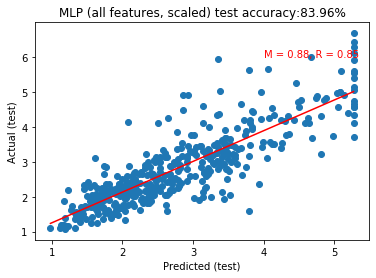

MLP (all features, scaled) accuracy: 82.23 %.


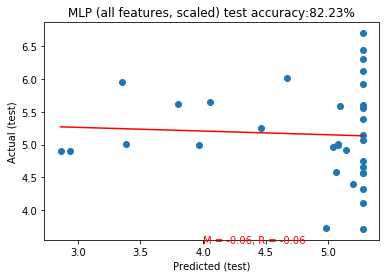

In [131]:
# MLP Regression with all features, scaled
MLP_analysis(X_train_scaled, X_test_scaled, 'MLP (all features, scaled)')

MLP accuracy (features= 20 ): 83.13 %.
MLP test score: 0.69


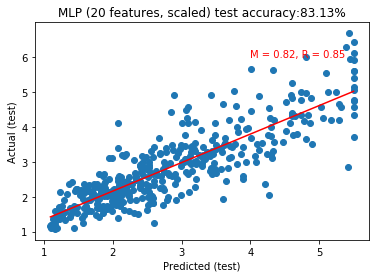

MLP (20 features, scaled) accuracy: 82.47 %.


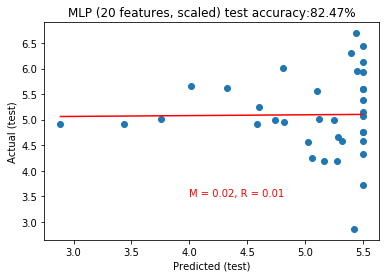

In [132]:
# MLP Regression with 20 features, scaled
MLP_analysis(X_train_scaled_20, X_test_scaled_20, 'MLP (20 features, scaled)')

MLP accuracy (features= 9 ): 64.88 %.
MLP test score: -0.0


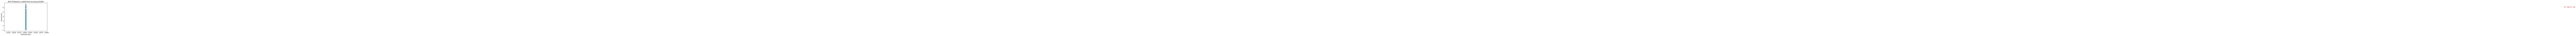

MLP (9 features, scaled) accuracy: 51.91 %.


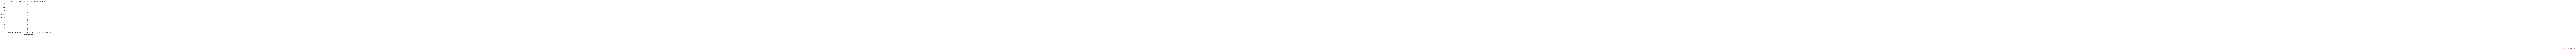

In [133]:
# MLP Regression with 9 features, scaled
MLP_analysis(X_train_scaled_9, X_test_scaled_9, 'MLP (9 features, scaled)')

In [ ]:
# MLP Regression with OLS features, scaled
MLP_analysis(X_train_scaled_OLS, X_test_scaled_OLS, 'MLP (OLS features, scaled)')

### Replace time-series TRC features with gradient type measure

#### Reduced features 8

In [77]:
# Replace 3 prior TRC with trend
# 
# num_TRC_periods_delta = 3
delta_decay = 0.0 # rate at which changes in periods prior to last in training set


In [78]:
# Calculate the change in TRC metrics between most recent feature (ie excluding the predictor period)
# and prior TRC periods for num_TRC_periods_delta, NB for SF401 this is only 3 periods
SDTopLeftDelta_train = (1.0*(X_train['SDTopLeft3']-X_train['SDTopLeft2'])+delta_decay*
                  (X_train['SDTopLeft2']-X_train['SDTopLeft1']))/(1+delta_decay)
SDTopRightDelta_train = (1.0*(X_train['SDTopRight3']-X_train['SDTopRight2'])+delta_decay*
                   (X_train['SDTopRight2']-X_train['SDTopRight1']))/(1+delta_decay)
SDTwist10Delta_train = (1.0*(X_train['SDTwist103']-X_train['SDTwist102'])+delta_decay*
                  (X_train['SDTwist102']-X_train['SDTwist101']))/(1+delta_decay)
SDTwist3Delta_train = (1.0*(X_train['SDTwist33']-X_train['SDTwist32'])+delta_decay*
                 (X_train['SDTwist32']-X_train['SDTwist31']))/(1+delta_decay)
SDVersLDelta_train = (1.0*(X_train['SDVersL3']-X_train['SDVersL2'])+delta_decay*
                (X_train['SDVersL2']-X_train['SDVersL1']))/(1+delta_decay)

delta_drop_features = ['SDTopLeft1', 'SDTopLeft2', 'SDTopRight1', 'SDTopRight2', 'SDTwist31', 'SDTwist32', 
                       'SDTwist101', 'SDTwist102', 'SDVersL1', 'SDVersL2', 'SDVersR1', 'SDVersR2']

# Specific to the dataframe
drop_cols = [c for c in delta_drop_features if c in X_train_9.index]
X_train_9D = X_train_9.drop(drop_cols, axis=1)
X_train_9D['SDTopLeftDelta'] = SDTopLeftDelta_train
X_train_9D['SDTopRightDelta'] = SDTopRightDelta_train
X_train_9D['SDTwist10Delta'] = SDTwist10Delta_train
X_train_9D['SDTwist3Delta'] = SDTwist3Delta_train
X_train_9D['SDVersLDelta'] = SDVersLDelta_train


In [79]:
# Test data
SDTopLeftDelta_test = (1.0*(X_test['SDTopLeft3']-X_test['SDTopLeft2'])+delta_decay*
                  (X_test['SDTopLeft2']-X_test['SDTopLeft1']))/(1+delta_decay)
SDTopRightDelta_test = (1.0*(X_test['SDTopRight3']-X_test['SDTopRight2'])+delta_decay*
                   (X_test['SDTopRight2']-X_test['SDTopRight1']))/(1+delta_decay)
SDTwist10Delta_test = (1.0*(X_test['SDTwist103']-X_test['SDTwist102'])+delta_decay*
                  (X_test['SDTwist102']-X_test['SDTwist101']))/(1+delta_decay)
SDTwist3Delta_test = (1.0*(X_test['SDTwist33']-X_test['SDTwist32'])+delta_decay*
                 (X_test['SDTwist32']-X_test['SDTwist31']))/(1+delta_decay)
SDVersLDelta_test = (1.0*(X_test['SDVersL3']-X_test['SDVersL2'])+delta_decay*
                (X_test['SDVersL2']-X_test['SDVersL1']))/(1+delta_decay)

# Specific to the dataframe
drop_cols = [c for c in delta_drop_features if c in X_test_9.index]
X_test_9D = X_test_9.drop(drop_cols, axis=1)
X_test_9D['SDTopLeftDelta'] = SDTopLeftDelta_test
X_test_9D['SDTopRightDelta'] = SDTopRightDelta_test
X_test_9D['SDTwist10Delta'] = SDTwist10Delta_test
X_test_9D['SDTwist3Delta'] = SDTwist3Delta_test
X_test_9D['SDVersLDelta'] = SDVersLDelta_test

In [80]:
# Train and scaled
SDTopLeftDelta_train_scaled = (1.0*(X_train_scaled['SDTopLeft3']-X_train_scaled['SDTopLeft2'])+delta_decay*
                  (X_train_scaled['SDTopLeft2']-X_train_scaled['SDTopLeft1']))/(1+delta_decay)
SDTopRightDelta_train_scaled = (1.0*(X_train_scaled['SDTopRight3']-X_train_scaled['SDTopRight2'])+delta_decay*
                   (X_train_scaled['SDTopRight2']-X_train_scaled['SDTopRight1']))/(1+delta_decay)
SDTwist10Delta_train_scaled = (1.0*(X_train_scaled['SDTwist103']-X_train_scaled['SDTwist102'])+delta_decay*
                  (X_train_scaled['SDTwist102']-X_train_scaled['SDTwist101']))/(1+delta_decay)
SDTwist3Delta_train_scaled = (1.0*(X_train_scaled['SDTwist33']-X_train_scaled['SDTwist32'])+delta_decay*
                 (X_train_scaled['SDTwist32']-X_train_scaled['SDTwist31']))/(1+delta_decay)
SDVersLDelta_train_scaled = (1.0*(X_train_scaled['SDVersL3']-X_train_scaled['SDVersL2'])+delta_decay*
                (X_train_scaled['SDVersL2']-X_train_scaled['SDVersL1']))/(1+delta_decay)

# Specific to the dataframe
drop_cols = [c for c in delta_drop_features if c in X_train_scaled_9.index]
X_train_scaled_9D = X_train_scaled_9.drop(drop_cols, axis=1)
X_train_scaled_9D['SDTopLeftDelta'] = SDTopLeftDelta_train_scaled
X_train_scaled_9D['SDTopRightDelta'] = SDTopRightDelta_train_scaled
X_train_scaled_9D['SDTwist10Delta'] = SDTwist10Delta_train_scaled
X_train_scaled_9D['SDTwist3Delta'] = SDTwist3Delta_train_scaled
X_train_scaled_9D['SDVersLDelta'] = SDVersLDelta_train_scaled

In [81]:
# Test and scaled
SDTopLeftDelta_test_scaled = (1.0*(X_test_scaled['SDTopLeft3']-X_test_scaled['SDTopLeft2'])+delta_decay*
                  (X_test_scaled['SDTopLeft2']-X_test_scaled['SDTopLeft1']))/(1+delta_decay)
SDTopRightDelta_test_scaled = (1.0*(X_test_scaled['SDTopRight3']-X_test_scaled['SDTopRight2'])+delta_decay*
                   (X_test_scaled['SDTopRight2']-X_test_scaled['SDTopRight1']))/(1+delta_decay)
SDTwist10Delta_test_scaled = (1.0*(X_test_scaled['SDTwist103']-X_test_scaled['SDTwist102'])+delta_decay*
                  (X_test_scaled['SDTwist102']-X_test_scaled['SDTwist101']))/(1+delta_decay)
SDTwist3Delta_test_scaled = (1.0*(X_test_scaled['SDTwist33']-X_test_scaled['SDTwist32'])+delta_decay*
                 (X_test_scaled['SDTwist32']-X_test_scaled['SDTwist31']))/(1+delta_decay)
SDVersLDelta_test_scaled = (1.0*(X_test_scaled['SDVersL3']-X_test_scaled['SDVersL2'])+delta_decay*
                (X_test_scaled['SDVersL2']-X_test_scaled['SDVersL1']))/(1+delta_decay)

# Specific to the dataframe
drop_cols = [c for c in delta_drop_features if c in X_test_scaled_9.index]
X_test_scaled_9D = X_test_scaled_9.drop(drop_cols, axis=1)
X_test_scaled_9D['SDTopLeftDelta'] = SDTopLeftDelta_test_scaled
X_test_scaled_9D['SDTopRightDelta'] = SDTopRightDelta_test_scaled
X_test_scaled_9D['SDTwist10Delta'] = SDTwist10Delta_test_scaled
X_test_scaled_9D['SDTwist3Delta'] = SDTwist3Delta_test_scaled
X_test_scaled_9D['SDVersLDelta'] = SDVersLDelta_test_scaled

In [82]:
# X_9D
SDTopLeftDelta = (1.0*(X['SDTopLeft3']-X['SDTopLeft2'])+delta_decay*
                  (X['SDTopLeft2']-X['SDTopLeft1']))/(1+delta_decay)
SDTopRightDelta = (1.0*(X['SDTopRight3']-X['SDTopRight2'])+delta_decay*
                   (X['SDTopRight2']-X['SDTopRight1']))/(1+delta_decay)
SDTwist10Delta = (1.0*(X['SDTwist103']-X['SDTwist102'])+delta_decay*
                  (X['SDTwist102']-X['SDTwist101']))/(1+delta_decay)
SDTwist3Delta = (1.0*(X['SDTwist33']-X['SDTwist32'])+delta_decay*
                 (X['SDTwist32']-X['SDTwist31']))/(1+delta_decay)
SDVersLDelta = (1.0*(X['SDVersL3']-X['SDVersL2'])+delta_decay*
                (X['SDVersL2']-X['SDVersL1']))/(1+delta_decay)

# Specific to the dataframe
drop_cols = [c for c in delta_drop_features if c in X_9.index]
X_9D = X_9.drop(drop_cols, axis=1)
X_9D['SDTopLeftDelta'] = SDTopLeftDelta
X_9D['SDTopRightDelta'] = SDTopRightDelta
X_9D['SDTwist10Delta'] = SDTwist10Delta
X_9D['SDTwist3Delta'] = SDTwist3Delta
X_9D['SDVersLDelta'] = SDVersLDelta

# X_scaled_9D
SDTopLeftDelta_scaled = (1.0*(X_scaled['SDTopLeft3']-X_scaled['SDTopLeft2'])+delta_decay*
                  (X_scaled['SDTopLeft2']-X_scaled['SDTopLeft1']))/(1+delta_decay)
SDTopRightDelta_scaled = (1.0*(X_scaled['SDTopRight3']-X_scaled['SDTopRight2'])+delta_decay*
                   (X['SDTopRight2']-X['SDTopRight1']))/(1+delta_decay)
SDTwist10Delta_scaled = (1.0*(X_scaled['SDTwist103']-X_scaled['SDTwist102'])+delta_decay*
                  (X_scaled['SDTwist102']-X_scaled['SDTwist101']))/(1+delta_decay)
SDTwist3Delta_scaled = (1.0*(X_scaled['SDTwist33']-X_scaled['SDTwist32'])+delta_decay*
                 (X_scaled['SDTwist32']-X_scaled['SDTwist31']))/(1+delta_decay)
SDVersLDelta_scaled = (1.0*(X_scaled['SDVersL3']-X_scaled['SDVersL2'])+delta_decay*
                (X_scaled['SDVersL2']-X_scaled['SDVersL1']))/(1+delta_decay)

# Specific to the dataframe
drop_cols = [c for c in delta_drop_features if c in X_9.index]
X_scaled_9D = X_scaled_9.drop(drop_cols, axis=1)
X_scaled_9D['SDTopLeftDelta'] = SDTopLeftDelta_scaled
X_scaled_9D['SDTopRightDelta'] = SDTopRightDelta_scaled
X_scaled_9D['SDTwist10Delta'] = SDTwist10Delta_scaled
X_scaled_9D['SDTwist3Delta'] = SDTwist3Delta_scaled
X_scaled_9D['SDVersLDelta'] = SDVersLDelta_scaled

In [83]:
# X_20
drop_cols = [c for c in delta_drop_features if c in X_train_scaled_20.index]

# Train
X_train_20D = X_train_20.drop(drop_cols, axis=1)
X_train_20D['SDTopLeftDelta'] = SDTopLeftDelta_train
X_train_20D['SDTopRightDelta'] = SDTopRightDelta_train
X_train_20D['SDTwist10Delta'] = SDTwist10Delta_train
X_train_20D['SDTwist3Delta'] = SDTwist3Delta_train
X_train_20D['SDVersLDelta'] = SDVersLDelta_train

# Test
X_test_20D = X_test_20.drop(drop_cols, axis=1)
X_test_20D['SDTopLeftDelta'] = SDTopLeftDelta_test
X_test_20D['SDTopRightDelta'] = SDTopRightDelta_test
X_test_20D['SDTwist10Delta'] = SDTwist10Delta_test
X_test_20D['SDTwist3Delta'] = SDTwist3Delta_test
X_test_20D['SDVersLDelta'] = SDVersLDelta_test

# Train and scaled
X_train_scaled_20D = X_train_scaled_20.drop(drop_cols, axis=1)
X_train_scaled_20D['SDTopLeftDelta'] = SDTopLeftDelta_train_scaled
X_train_scaled_20D['SDTopRightDelta'] = SDTopRightDelta_train_scaled
X_train_scaled_20D['SDTwist10Delta'] = SDTwist10Delta_train_scaled
X_train_scaled_20D['SDTwist3Delta'] = SDTwist3Delta_train_scaled
X_train_scaled_20D['SDVersLDelta'] = SDVersLDelta_train_scaled

# Test and scaled
X_test_scaled_20D = X_test_scaled_20.drop(drop_cols, axis=1)
X_test_scaled_20D['SDTopLeftDelta'] = SDTopLeftDelta_test_scaled
X_test_scaled_20D['SDTopRightDelta'] = SDTopRightDelta_test_scaled
X_test_scaled_20D['SDTwist10Delta'] = SDTwist10Delta_test_scaled
X_test_scaled_20D['SDTwist3Delta'] = SDTwist3Delta_test_scaled
X_test_scaled_20D['SDVersLDelta'] = SDVersLDelta_test_scaled

# X_20
drop_cols = [c for c in delta_drop_features if c in X_20.index]
X_20D = X_20.drop(drop_cols, axis=1)
X_20D['SDTopLeftDelta'] = SDTopLeftDelta
X_20D['SDTopRightDelta'] = SDTopRightDelta
X_20D['SDTwist10Delta'] = SDTwist10Delta
X_20D['SDTwist3Delta'] = SDTwist3Delta
X_20D['SDVersLDelta'] = SDVersLDelta

# X_scaled_20
drop_cols = [c for c in delta_drop_features if c in X_20.index]
X_scaled_20D = X_scaled_20.drop(drop_cols, axis=1)
X_scaled_20D['SDTopLeftDelta'] = SDTopLeftDelta_scaled
X_scaled_20D['SDTopRightDelta'] = SDTopRightDelta_scaled
X_scaled_20D['SDTwist10Delta'] = SDTwist10Delta_scaled
X_scaled_20D['SDTwist3Delta'] = SDTwist3Delta_scaled
X_scaled_20D['SDVersLDelta'] = SDVersLDelta_scaled

In [84]:
# X_OLS
drop_cols = [c for c in delta_drop_features if c in X_train_scaled_OLS.index]

# Train
X_train_OLSD = X_train_OLS.drop(drop_cols, axis=1)
X_train_OLSD['SDTopLeftDelta'] = SDTopLeftDelta_train
X_train_OLSD['SDTopRightDelta'] = SDTopRightDelta_train
X_train_OLSD['SDTwist10Delta'] = SDTwist10Delta_train
X_train_OLSD['SDTwist3Delta'] = SDTwist3Delta_train
X_train_OLSD['SDVersLDelta'] = SDVersLDelta_train

# Test
X_test_OLSD = X_test_OLS.drop(drop_cols, axis=1)
X_test_OLSD['SDTopLeftDelta'] = SDTopLeftDelta_test
X_test_OLSD['SDTopRightDelta'] = SDTopRightDelta_test
X_test_OLSD['SDTwist10Delta'] = SDTwist10Delta_test
X_test_OLSD['SDTwist3Delta'] = SDTwist3Delta_test
X_test_OLSD['SDVersLDelta'] = SDVersLDelta_test

# Train and scaled
X_train_scaled_OLSD = X_train_scaled_OLS.drop(drop_cols, axis=1)
X_train_scaled_OLSD['SDTopLeftDelta'] = SDTopLeftDelta_train_scaled
X_train_scaled_OLSD['SDTopRightDelta'] = SDTopRightDelta_train_scaled
X_train_scaled_OLSD['SDTwist10Delta'] = SDTwist10Delta_train_scaled
X_train_scaled_OLSD['SDTwist3Delta'] = SDTwist3Delta_train_scaled
X_train_scaled_OLSD['SDVersLDelta'] = SDVersLDelta_train_scaled

# Test and scaled
X_test_scaled_OLSD = X_test_scaled_OLS.drop(drop_cols, axis=1)
X_test_scaled_OLSD['SDTopLeftDelta'] = SDTopLeftDelta_test_scaled
X_test_scaled_OLSD['SDTopRightDelta'] = SDTopRightDelta_test_scaled
X_test_scaled_OLSD['SDTwist10Delta'] = SDTwist10Delta_test_scaled
X_test_scaled_OLSD['SDTwist3Delta'] = SDTwist3Delta_test_scaled
X_test_scaled_OLSD['SDVersLDelta'] = SDVersLDelta_test_scaled

# X_OLS
X_OLSD = X_OLS.drop(drop_cols, axis=1)
X_OLSD['SDTopLeftDelta'] = SDTopLeftDelta
X_OLSD['SDTopRightDelta'] = SDTopRightDelta
X_OLSD['SDTwist10Delta'] = SDTwist10Delta
X_OLSD['SDTwist3Delta'] = SDTwist3Delta
X_OLSD['SDVersLDelta'] = SDVersLDelta

# X_OLS_scaled
X_scaled_OLSD = X_scaled_OLS.drop(drop_cols, axis=1)
X_scaled_OLSD['SDTopLeftDelta'] = SDTopLeftDelta_scaled
X_scaled_OLSD['SDTopRightDelta'] = SDTopRightDelta_scaled
X_scaled_OLSD['SDTwist10Delta'] = SDTwist10Delta_scaled
X_scaled_OLSD['SDTwist3Delta'] = SDTwist3Delta_scaled
X_scaled_OLSD['SDVersLDelta'] = SDVersLDelta_scaled

#### Random Forest using delta feature

RF (20 features, unscaled, gradient) 85.23 %.
RF test score: 0.77
Out of bag score: 0.7997


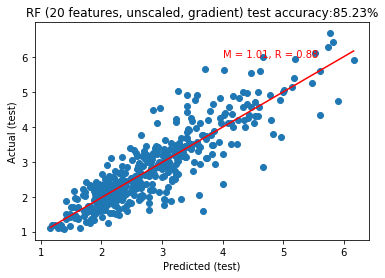

RF (20 features, unscaled, gradient) accuracy: 85.37 %.


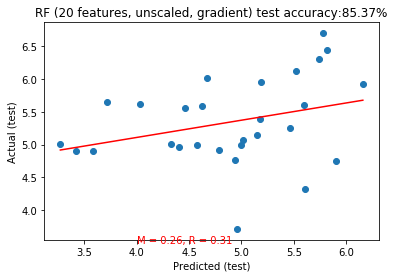

In [147]:
# RF unscaled, 20 features
RF_analysis(X_train_20D, X_test_20D, 'RF (20 features, unscaled, gradient)', 1000)

RF (9 features, unscaled, gradient) 84.74 %.
RF test score: 0.757
Out of bag score: 0.78


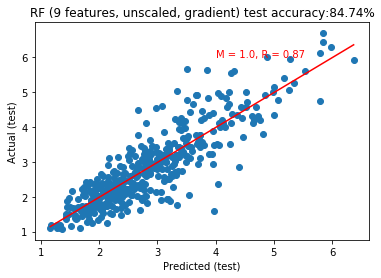

RF (9 features, unscaled, gradient) accuracy: 86.23 %.


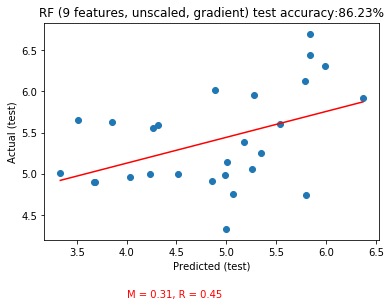

In [148]:
# RF unscaled, 9 features
RF_analysis(X_train_9D, X_test_9D, 'RF (9 features, unscaled, gradient)', 1000)

RF (OLS features, unscaled, gradient) 85.13 %.
RF test score: 0.766
Out of bag score: 0.7964


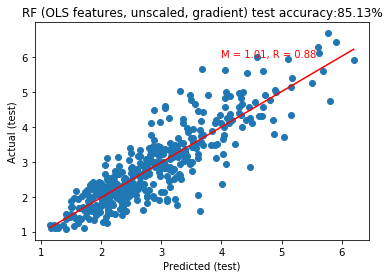

RF (OLS features, unscaled, gradient) accuracy: 84.78 %.


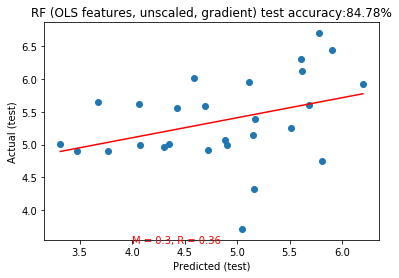

In [149]:
# RF unscaled, OLS features
RF_analysis(X_train_OLSD, X_test_OLSD, 'RF (OLS features, unscaled, gradient)', 1000)

#### SVR using delta feature

SVR accuracy: 84.28 %.
SVR test score: 0.752


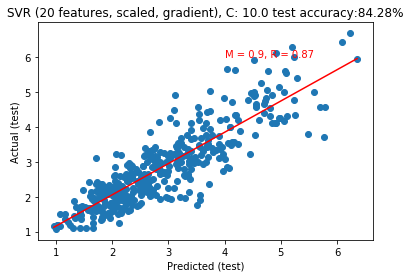

SVR (20 features, scaled, gradient), C: 10.0 accuracy: 83.29 %.


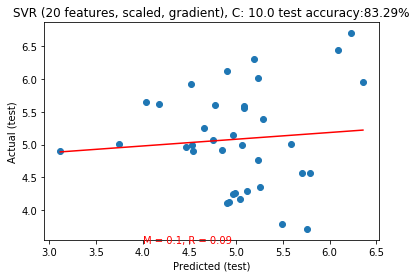

In [150]:
# Use gradient, 20 features
SVR_string = 'SVR (20 features, scaled, gradient), C: ' + str(SVR_best_C)
SVRaccuracy, SVRtest_score = SVR_analysis(X_train_scaled_20D, X_test_scaled_20D, SVR_string, 'rbf', SVR_best_C, 
                                          0.01, plot_option=True, poly_degree=0)

SVR accuracy: 82.92 %.
SVR test score: 0.688


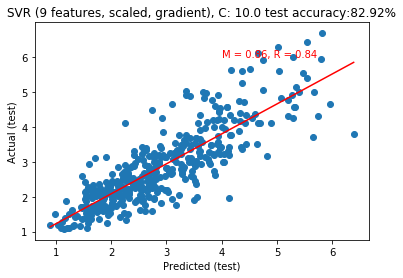

SVR (9 features, scaled, gradient), C: 10.0 accuracy: 80.78 %.


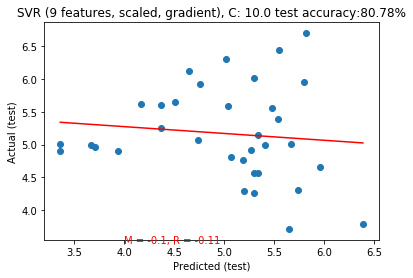

In [161]:
# Use gradient, 9 features
SVR_string = 'SVR (9 features, scaled, gradient), C: ' + str(SVR_best_C)
SVRaccuracy, SVRtest_score = SVR_analysis(X_train_scaled_9D, X_test_scaled_9D, SVR_string, 'rbf', SVR_best_C, 
                                          0.01, plot_option=True, poly_degree=0)

SVR accuracy: 83.78 %.
SVR test score: 0.752


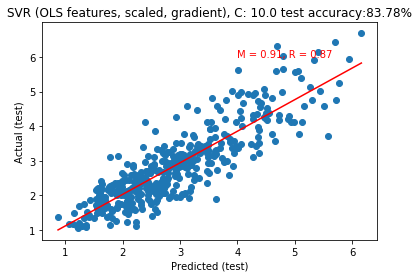

SVR (OLS features, scaled, gradient), C: 10.0 accuracy: 84.17 %.


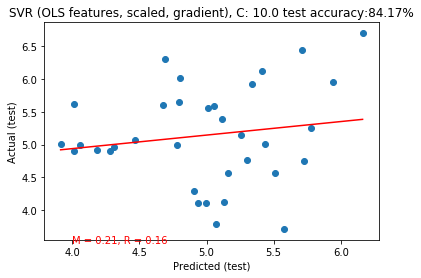

In [153]:
# Use gradient, OLS features
SVR_string = 'SVR (OLS features, scaled, gradient), C: ' + str(SVR_best_C)
SVRaccuracy, SVRtest_score = SVR_analysis(X_train_scaled_OLSD, X_test_scaled_OLSD, SVR_string, 'rbf', SVR_best_C, 
                                          0.01, plot_option=True, poly_degree=0)

#### KNN gradient feature

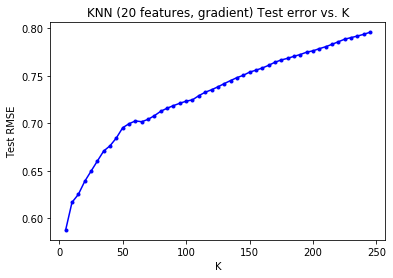

Optimal K: 5
KNN accuracy (features= 25 ): 83.74 %.
KNN test score: 0.713


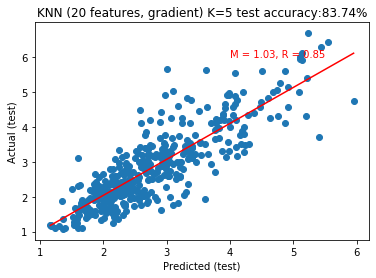

KNN (20 features, gradient) K=5 accuracy: 81.02 %.


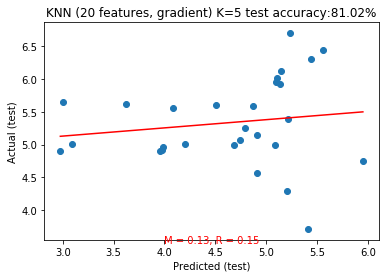

In [165]:
# 20 features, gradient
KNN_analysis(X_train_scaled_20D, X_test_scaled_20D, 'KNN (20 features, gradient)')

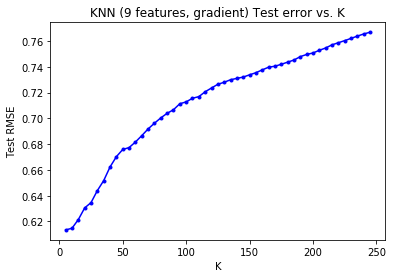

Optimal K: 5
KNN accuracy (features= 14 ): 82.86 %.
KNN test score: 0.688


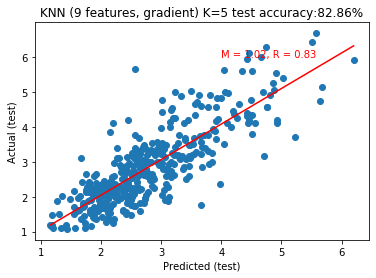

KNN (9 features, gradient) K=5 accuracy: 80.19 %.


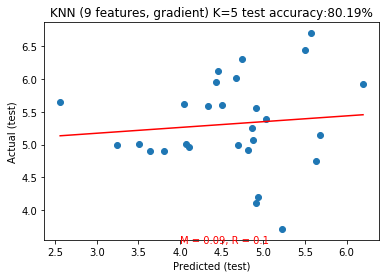

In [166]:
# 9 features, gradient
KNN_analysis(X_train_scaled_9D, X_test_scaled_9D, 'KNN (9 features, gradient)')

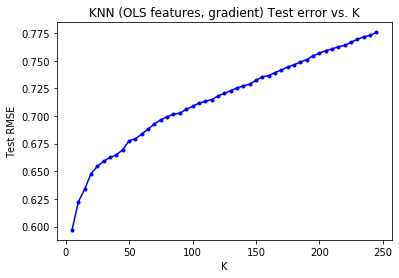

Optimal K: 5
KNN accuracy (features= 24 ): 83.66 %.
KNN test score: 0.704


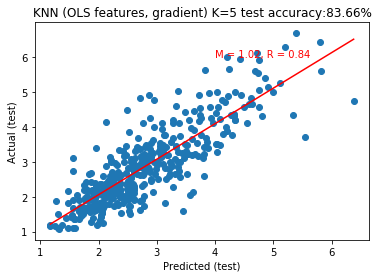

KNN (OLS features, gradient) K=5 accuracy: 80.4 %.


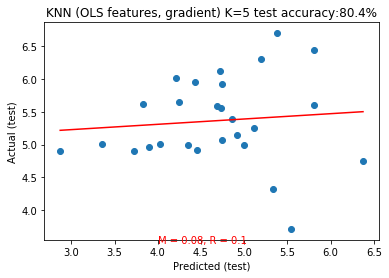

In [167]:
# OLS features, gradient
KNN_analysis(X_train_scaled_OLSD, X_test_scaled_OLSD, 'KNN (OLS features, gradient)')

#### ANN using gradient feature

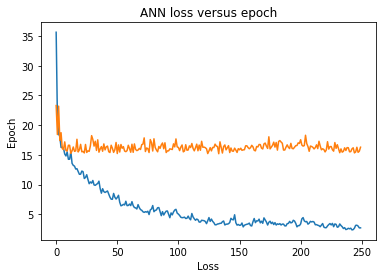

ANN accuracy (features= 25 ): 84.81 %.


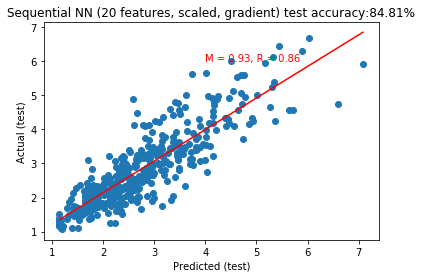

Sequential NN (20 features, scaled, gradient) accuracy: 82.99 %.


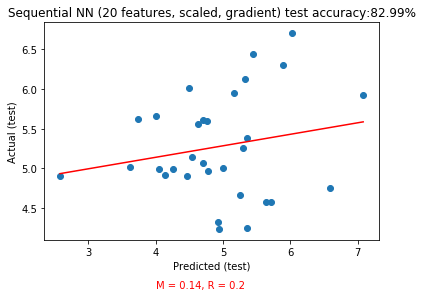

In [162]:
# 20 features, scaled, gradient feature
ANNes_analysis(X_train_scaled_20D, X_test_scaled_20D, 'Sequential NN (20 features, scaled, gradient)')

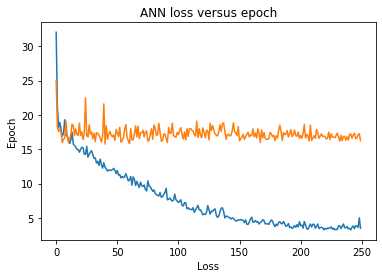

ANN accuracy (features= 14 ): 84.24 %.


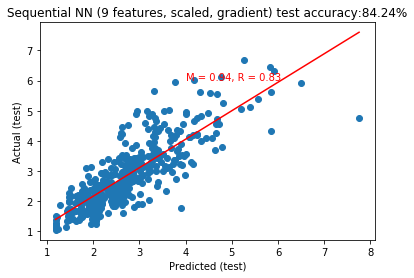

Sequential NN (9 features, scaled, gradient) accuracy: 77.16 %.


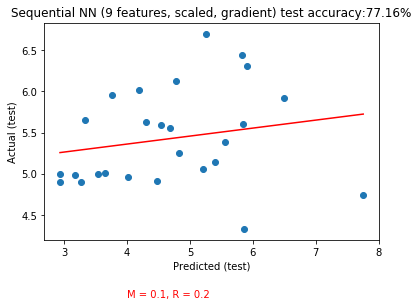

In [163]:
# 9 features, scaled, gradient feature
ANNes_analysis(X_train_scaled_9D, X_test_scaled_9D, 'Sequential NN (9 features, scaled, gradient)')

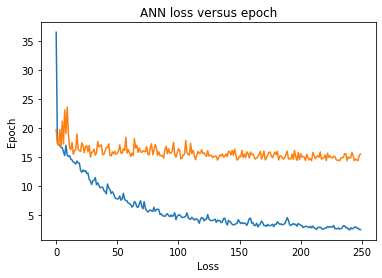

ANN accuracy (features= 24 ): 85.63 %.


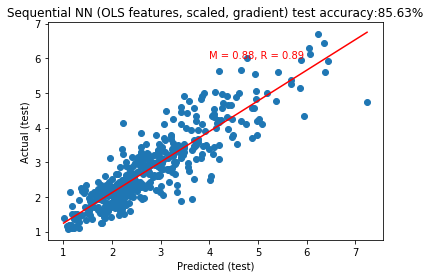

Sequential NN (OLS features, scaled, gradient) accuracy: 85.55 %.


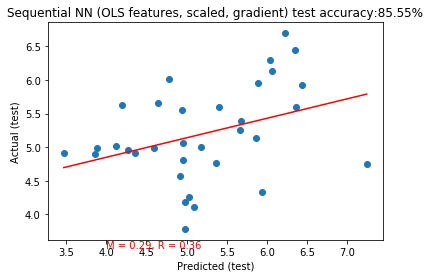

In [164]:
# OLS features, scaled, gradient feature
ANNes_analysis(X_train_scaled_OLSD, X_test_scaled_OLSD, 'Sequential NN (OLS features, scaled, gradient)')

### Consider predictive power 2 quarters in advance

#### Check baseline

Baseline accuracy (using most recent TRC only): 51.86 %.


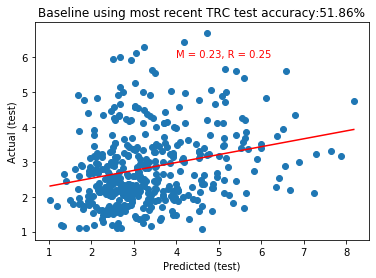

Baseline (most recent TRC value) accuracy: 28.78 %.


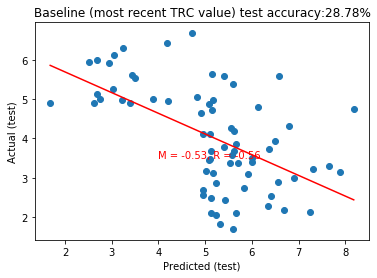

In [85]:
baseline3_pred = featureDF.loc[indices_test,'Combined2'] # Use 2nd most recent TRC 'Combined' value
baseline3_errors = abs(baseline3_pred - y_test)

# Calculate mean absolute percentage error (MAPE)
baseline3mape = 100 * (baseline3_errors / y_test)
baseline3accuracy = 100 - np.mean(baseline3mape)
print('Baseline accuracy (using most recent TRC only):', round(baseline3accuracy, 2), '%.')

plot_predicted_actual(baseline3_pred, 'Baseline using most recent TRC', baseline3accuracy)
assessPriorityPredictions(baseline3_pred.values, "Baseline (most recent TRC value)", combined_priority)

#### Compare with RF

Random Forest (all features, unscaled, Ex TRC3) 74.19 %.
RF test score: 0.434
Out of bag score: 0.439


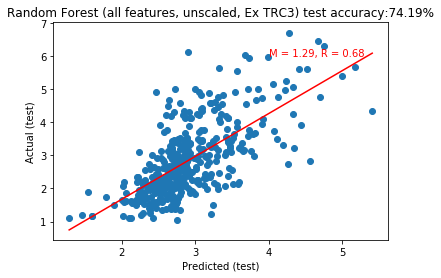

Random Forest (all features, unscaled, Ex TRC3) accuracy: 70.93 %.


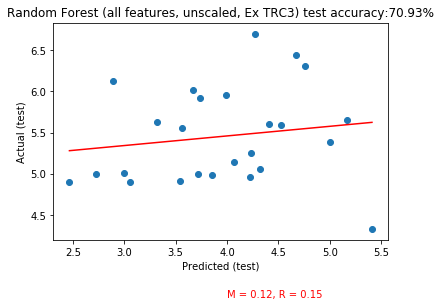

In [86]:
# Create training dataset without most recent TRC information
TRC3_features = ['SDTopLeft3', 'SDTopRight3', 'SDTwist33', 'SDTwist103', 'SDVersL3', 'SDVersR3']
X_train_2 = X_train.drop(TRC3_features, axis=1)
X_test_2 = X_test.drop(TRC3_features, axis=1)

# RF unscaled, all features excluding most recent TRC 
RF_analysis(X_train_2, X_test_2, y_train, y_test, 'Random Forest (all features, unscaled, Ex TRC3)', 1000)